In [47]:
################################################################################################################################
#
# FRACDIFF - DAILY
#
################################################################################################################################

#===============================================================================================================================
# LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#===============================================================================================================================
# CONFIG
#===============================================================================================================================
%matplotlib inline
#plt.style.use('seaborn-darkgrid')
warnings.filterwarnings('ignore')

In [48]:
#===============================================================================================================================
# PRICE - DATA: READ
#===============================================================================================================================
seriesId = 'IBOV'
df = pd.read_csv(seriesId+'.csv')

data = df.copy()
data['Date'] =pd.to_datetime(data['Date'], dayfirst=True)
data = data.loc[:, ['Date', 'Close']]
data = data.set_index('Date')
data

,Close
Date,
2000-01-03,16930.42
2000-01-04,15851.00
2000-01-05,16245.14
2000-01-06,16106.89
2000-01-07,16309.15
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


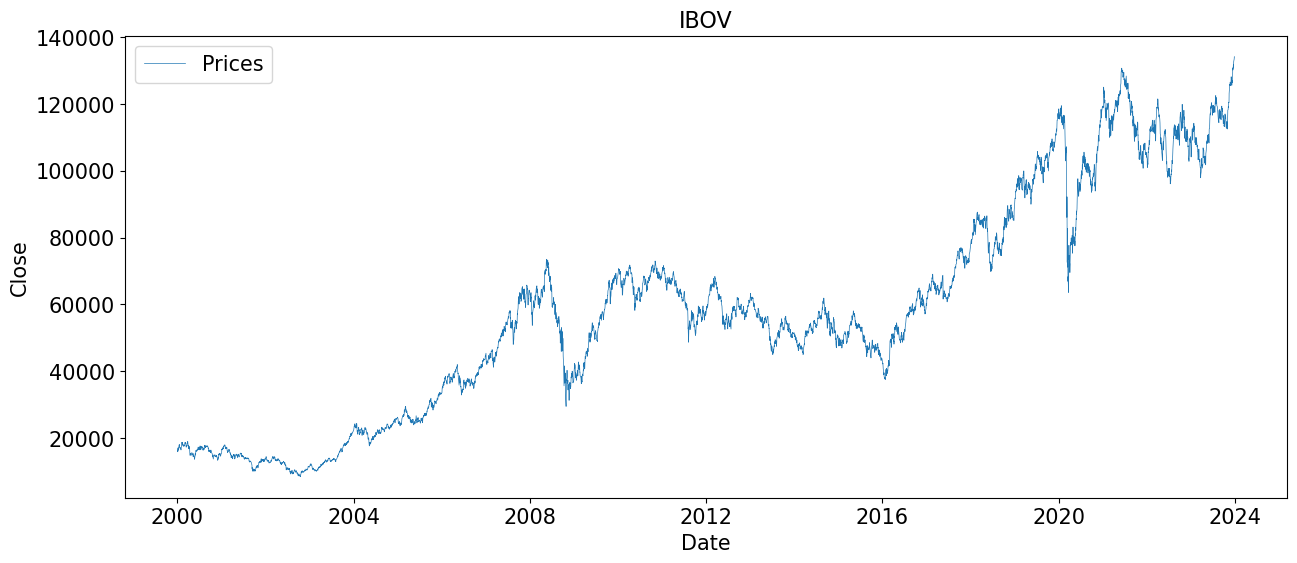

In [49]:
#===============================================================================================================================
# PRICE - DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(data.index, data['Close'], label = "Prices", linewidth=0.5)
plt.title(seriesId, fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()

In [50]:
#===============================================================================================================================
# PRICE - TRANSF: CONSTANTS
#===============================================================================================================================
THRESHOLD = 1e-4


In [51]:
#===============================================================================================================================
# PRICE - TRANSF: FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [52]:
#===============================================================================================================================
# PRICE - TRANSF: FUNCTION FRACDIFF
#===============================================================================================================================
def fracDiff_FFD(series,d,thres=THRESHOLD, w=None):
    #---------------------------------------------------------------------------------------------------------------------------
    # Constant width window (new solution)
    # thres: cut-off weight for the window
    # d: positive fractional, not necessarily bounded [0,1].
    #---------------------------------------------------------------------------------------------------------------------------

    #---------------------------------------------------------------------------------------------------------------------------
    # 1) WEIGHTS
    #---------------------------------------------------------------------------------------------------------------------------
    length = len(series)                                            # Get the length of the series
    #print('len(series)=',length)
    if w is None:                                                   # if w = none
        #w=getWeights_FFD(d,thres,length)                          # Estimate w 
        w=getWeights_FFD(d,thres,)                               # Estimate w 
    width=len(w)-1                                                  # Width define the span of residuals
    
    #print('len(w)=',len(w))
    #print('w')
    #print(np.round(w[-20:],4))
    #print('width=' ,width)

    #---------------------------------------------------------------------------------------------------------------------------
    # 2) Apply WEIGHTS to VALUES
    #---------------------------------------------------------------------------------------------------------------------------
    df= {}
    seriesF,df_=series.fillna(method='ffill').dropna(), pd.Series() # seriesF (forward-filled) and df_ (empty series)
    #print('len(seriesF)=', len(seriesF))
    
    #print('loop for: len(seriesF.index)', len(seriesF.index))
    for iloc1 in range(width,len(seriesF.index)):                   # Loop through each observation of the seriesF
        loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]      # Get first and last loc's for residuals
        if not np.isfinite(series.loc[loc1]):continue                  # Exclude NAs
        df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0]                # Compute residuals for loc1
    df['Close']=df_.copy(deep=True)                                 # Create residuals of the respective OHLC dataframe
    df=pd.concat(df,axis=1)                                         # Convert the series into a dataframe

    #print('len(df_)=', len(df_))
    #print(seriesF[-20:])
    #print(df_[-20:])

    return df


In [53]:
#===============================================================================================================================
# PRICE - TRANSF: FUNCTION - d ESTIMATES (ADF statistics)
#===============================================================================================================================
def d_estimates_db(DF,minimum,maximum):
    #---------------------------------------------------------------------------------------------------------------------------
    # Create the output dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    #---------------------------------------------------------------------------------------------------------------------------
    # Copy the dataframe in order to not change it
    #---------------------------------------------------------------------------------------------------------------------------
    df0=DF.copy()
    #---------------------------------------------------------------------------------------------------------------------------
    # Create a range of posible d values and loop throughout them
    #---------------------------------------------------------------------------------------------------------------------------
    for d in np.linspace(minimum,maximum,11):
        #--------------------------------------------------------------------
        # Create the log of close prices
        #--------------------------------------------------------------------
        #df1=np.log(df0['Close'])
        df1=df0['Close']
        #--------------------------------------------------------------------
        # Estimate the FracDiff residuals
        #--------------------------------------------------------------------
        df2=fracDiff_FFD(df1,d,thres=THRESHOLD)
        #--------------------------------------------------------------------
        # Correlation between the log prices and the FracDiff residuals
        #--------------------------------------------------------------------
        corr=np.corrcoef(df1.loc[df2.index],df2['Close'])[0,1]

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('d_estimates_db: d =',round(d,3), '  correlation =', round(corr,3))
        #print('df2')
        #print(df2)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        #--------------------------------------------------------------------
        # Estimate a unit root test to the FraDiff residuals
        #--------------------------------------------------------------------
        df2=adfuller(df2['Close'],regression='c',autolag='AIC')
        #--------------------------------------------------------------------
        # Save all the results in the out dataframe
        #--------------------------------------------------------------------
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    # Return the out dataframe            
    return out

In [54]:
#===============================================================================================================================
# PRICE - TRANSF: FUNCTION OPTIMAL d
#===============================================================================================================================
def optimal_d(DF, alpha=0.035, minimum = 0, maximum = 1):
    #---------------------------------------------------------------------------------------------------------------------------
    # Copy the dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df = DF.copy()
    #---------------------------------------------------------------------------------------------------------------------------
    # Estimate the best d based on the basic d range
    #---------------------------------------------------------------------------------------------------------------------------
    path = './Data/Output/1.Econometric-4.FracDiff-1.Daily/'
    out = d_estimates_db(df,minimum,maximum)
    out.to_excel(path+'optimal_d-out1.xlsx')
    #---------------------------------------------------------------------------------------------------------------------------
    # A try-except block to handle erros while getting a d with better decimals
    #---------------------------------------------------------------------------------------------------------------------------
    try:
        #-----------------------------------------------------------------------------------------------------------------------
        # Get the d value which critical value is closest to and higher than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d1 = out[out['pVal']>alpha].index.values[-1]
        #-----------------------------------------------------------------------------------------------------------------------
        # Get the d value which critical value is closest to and lower than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d2 = out[out['pVal']<alpha].index.values[0]
        #-----------------------------------------------------------------------------------------------------------------------
        # Estimate the best d between d1 and d2
        #-----------------------------------------------------------------------------------------------------------------------
        out = d_estimates_db(df,d1,d2)
        out.to_excel(path+'optimal_d-out2.xlsx')
        try:
            #-------------------------------------------------------------------------------------------------------------------
            # Get the d value which critical value is closest to and higher than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d1 = out[out['pVal']>alpha].index.values[-1]
            #-------------------------------------------------------------------------------------------------------------------
            # Get the d value which critical value is closest to and lower than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d2 = out[out['pVal']<alpha].index.values[0]
            #-------------------------------------------------------------------------------------------------------------------
            # Estimate the best d between d1 and d2
            #-------------------------------------------------------------------------------------------------------------------
            out = d_estimates_db(df,d1,d2)
            out.to_excel(path+'optimal_d-out3.xlsx')
            try:
                #---------------------------------------------------------------------------------------------------------------
                # Get the d value which critical value is closest to and higher than alpha
                #---------------------------------------------------------------------------------------------------------------
                d1 = out[out['pVal']>alpha].index.values[-1]
                #---------------------------------------------------------------------------------------------------------------
                # Get the d value which critical value is closest to and lower than alpha
                #---------------------------------------------------------------------------------------------------------------
                d2 = out[out['pVal']<alpha].index.values[0]
                #---------------------------------------------------------------------------------------------------------------
                # Set d as the average between d1 and d2 with four decimals
                #---------------------------------------------------------------------------------------------------------------
                d = round((d1+d2)/2,4)    
            except:
                #---------------------------------------------------------------------------------------------------------------
                # In case the try fails, assign d with the critical value which is closest to and higher than alpha
                #---------------------------------------------------------------------------------------------------------------
                d = out[out['pVal']<alpha].index.values[0]
        except:
            #-------------------------------------------------------------------------------------------------------------------
            # In case the try fails, assign d with the critical value which is closest to and higher than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d = out[out['pVal']<alpha].index.values[0]
    except:
        #-----------------------------------------------------------------------------------------------------------------------
        # In case the try fails, assign d with the critical value which is closest to and higher than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d = out[out['pVal']<alpha].index.values[0]
    # Return the d value
    return d

In [55]:
#===============================================================================================================================
# PRICE - TRANSF: RUN - d ESTIMATES
#===============================================================================================================================
out = d_estimates_db(data,0,1)
out

#-----------------------------------------------------------------
# diff   adfStat          pVal  lags    nObs   95% conf      corr
#-----------------------------------------------------------------
# 0.0  -0.463371  8.989684e-01  11.0  5931.0  -2.862027  1.000000
# 0.1  -1.297984  6.300941e-01   7.0  5433.0  -2.862072  0.995251
# 0.2  -2.320128  1.655583e-01   6.0  5440.0  -2.862071  0.973129
# 0.3  -3.218056  1.896303e-02  15.0  5540.0  -2.862062  0.928268
# 0.4  -3.802464  2.882210e-03  26.0  5635.0  -2.862053  0.852800
# 0.5  -4.951445  2.766524e-05  26.0  5717.0  -2.862046  0.739250
# 0.6  -6.218377  5.296934e-08  26.0  5777.0  -2.862040  0.591374
# 0.7  -7.333671  1.110861e-10  28.0  5818.0  -2.862037  0.427604
# 0.8  -8.930194  9.862735e-15  28.0  5851.0  -2.862034  0.282918
# 0.9 -14.201131  1.787042e-26  16.0  5889.0  -2.862031  0.162188
# 1.0 -21.237276  0.000000e+00  10.0  5931.0  -2.862027  0.026296

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.995
d_estimates_db: d = 0.2   correlation = 0.973
d_estimates_db: d = 0.3   correlation = 0.928
d_estimates_db: d = 0.4   correlation = 0.853
d_estimates_db: d = 0.5   correlation = 0.739
d_estimates_db: d = 0.6   correlation = 0.591
d_estimates_db: d = 0.7   correlation = 0.428
d_estimates_db: d = 0.8   correlation = 0.283
d_estimates_db: d = 0.9   correlation = 0.162
d_estimates_db: d = 1.0   correlation = 0.026


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.463371,8.989684e-01,11.0,5931.0,-2.862027,1.000000
0.1,-1.297984,6.300941e-01,7.0,5433.0,-2.862072,0.995251
0.2,-2.320128,1.655583e-01,6.0,5440.0,-2.862071,0.973129
0.3,-3.218056,1.896303e-02,15.0,5540.0,-2.862062,0.928268
0.4,-3.802464,2.882210e-03,26.0,5635.0,-2.862053,0.852800
0.5,-4.951445,2.766524e-05,26.0,5717.0,-2.862046,0.739250
0.6,-6.218377,5.296934e-08,26.0,5777.0,-2.862040,0.591374
0.7,-7.333671,1.110861e-10,28.0,5818.0,-2.862037,0.427604
0.8,-8.930194,9.862735e-15,28.0,5851.0,-2.862034,0.282918
0.9,-14.201131,1.787042e-26,16.0,5889.0,-2.862031,0.162188


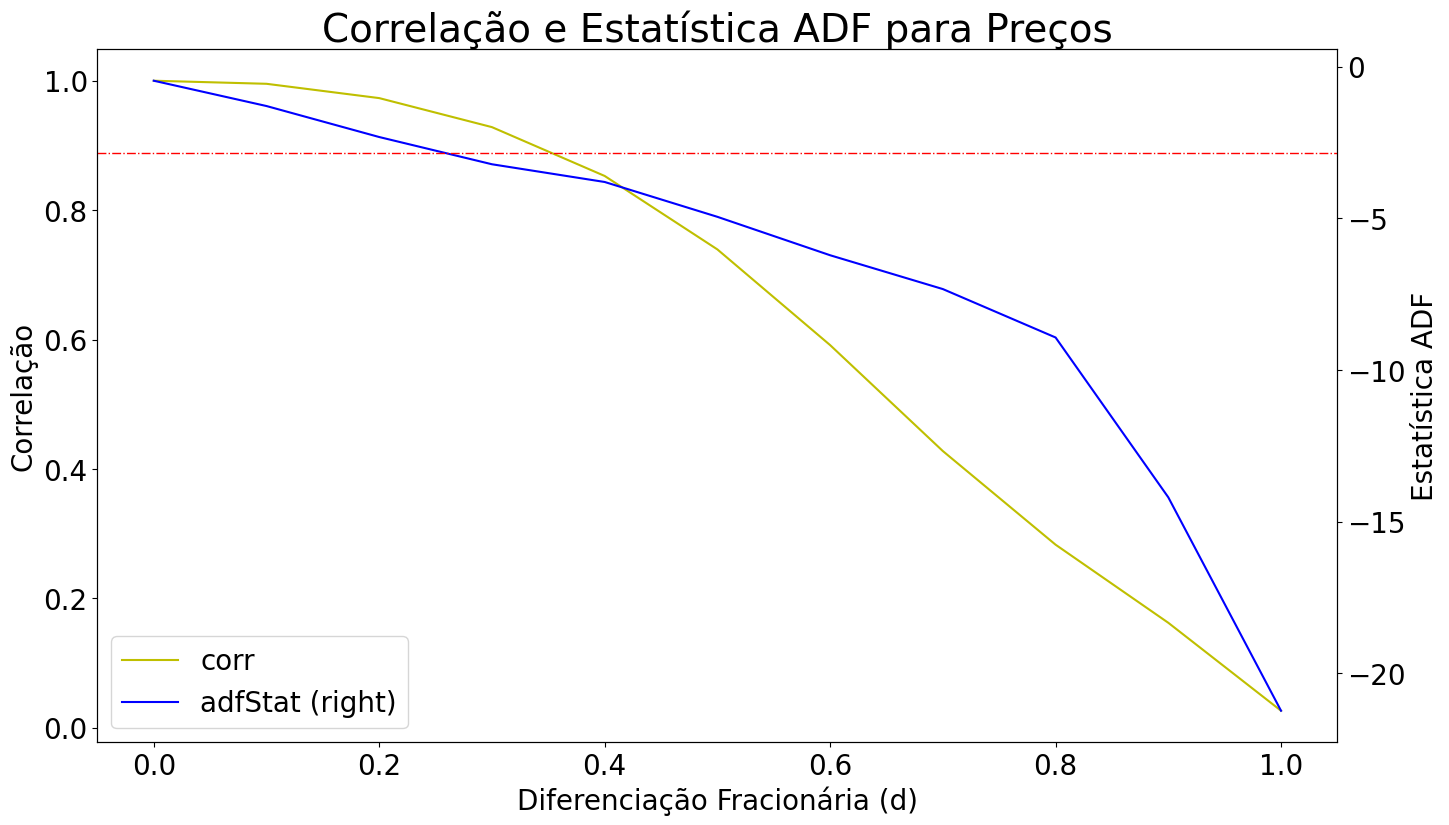

In [56]:
#===============================================================================================================================
# PRICE - TRANSF: PLOT - ADF TEST and CORRELATION vs d
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# Plot: out For d = 0.3 , p-value = 0.048, correlation = 0.85 > 0.8 (critical point).
#-------------------------------------------------------------------------------------------------------------------------------
ax1 = out['corr'].plot(figsize=(16, 9), color='y')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='b', ax=ax1)
ax1.set_title('Correlação e Estatística ADF para Preços', fontsize=28)
ax1.set_xlabel('Diferenciação Fracionária (d)', fontsize=20)
ax1.set_ylabel('Correlação', fontsize=20)
ax2.set_ylabel('Estatística ADF', fontsize=20)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)
plt.axhline(out['95% conf'].mean(),linewidth=1, color='r',linestyle='-.');
# Tip: get 2 legends aligned without overlapping:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)

In [57]:
#===============================================================================================================================
# PRICE - TRANSF: OPTIMAL d
#===============================================================================================================================
#d = optimal_d(data, 0.035, 0, 1)
d = 0.2485
d
#-------------------------------------------------------------------------------------------------------------------------------
# d = 0.2485
#-------------------------------------------------------------------------------------------------------------------------------

0.2485

In [58]:
#===============================================================================================================================
# PRICE - TRANSF: FFD
#===============================================================================================================================
fracdiff_residuals = fracDiff_FFD(data['Close'],d)
fracdiff_residuals

,Close
2001-10-18,1352.109469
2001-10-19,1738.220882
2001-10-22,2036.189415
2001-10-23,1833.354429
2001-10-24,1661.228961
...,...
2023-12-21,28560.747482
2023-12-22,28708.794508
2023-12-26,29129.784786
2023-12-27,29383.339887


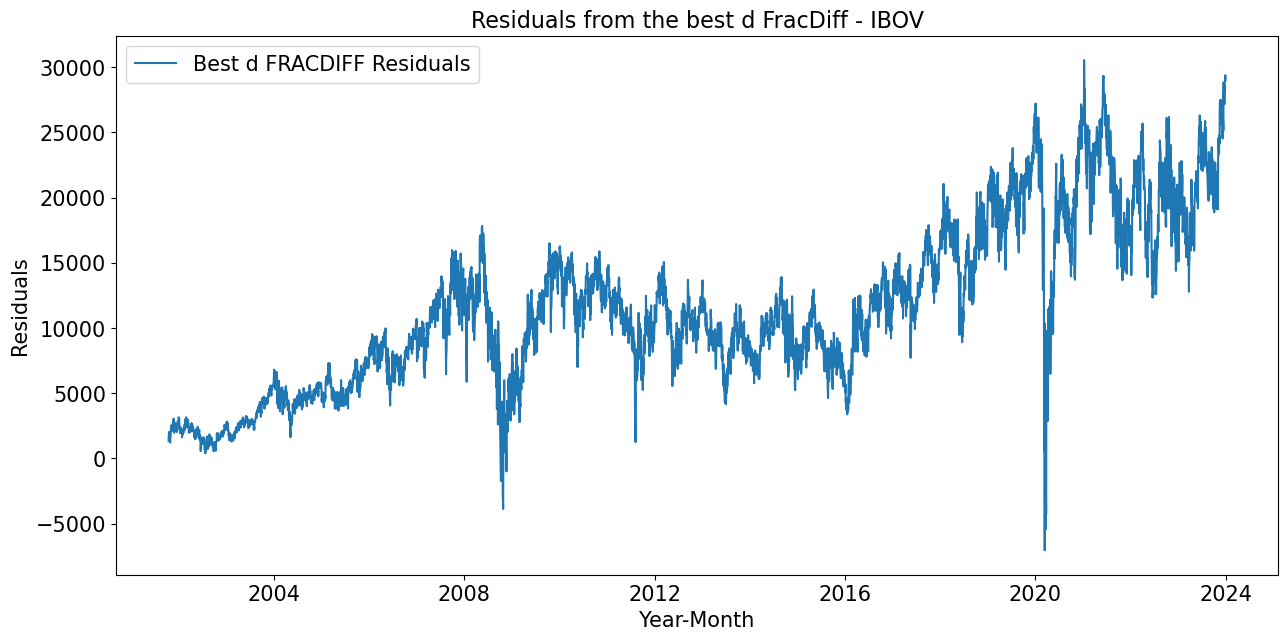

In [59]:
#===============================================================================================================================
# PRICE - TRANSF: FFD - PLOT
#===============================================================================================================================

# Set the figure size
plt.figure(figsize=(15,7))

# Plot the residuals
plt.plot(fracdiff_residuals.index, fracdiff_residuals, label = "Best d FRACDIFF Residuals")

# Set the title of the graph
plt.title('Residuals from the best d FracDiff - IBOV', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [60]:
#===============================================================================================================================
# PRICE - TRANSF: FFD - STATIONARITY (ADF Test)
#===============================================================================================================================
df2=adfuller(fracdiff_residuals, regression='c', autolag='AIC')
ADF_statistics = df2[0]
p_value = df2[1]
print('ADF statistics =', round(ADF_statistics,2),chr(9), 'p_value =', round(p_value,3))

#-------------------------------------------------------------------------------------------------------------------------------
# ADF statistics = -2.99 p_value = 0.036 < 0.05
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF statistics = -2.99 	 p_value = 0.036


In [61]:
#===============================================================================================================================
# PRICE - TRANSF: FFD - CORRELATION
#===============================================================================================================================
fracdiff_residuals.rename(columns={'Close':'Residuals'}, inplace=True)
new_df = pd.concat([data['Close'], fracdiff_residuals], axis=1).dropna()
print('Correlation = ', round(new_df.corr().loc['Close','Residuals'],4))

#-------------------------------------------------------------------------------------------------------------------------------
# Correlation =  0.9546
#-------------------------------------------------------------------------------------------------------------------------------

Correlation =  0.9546


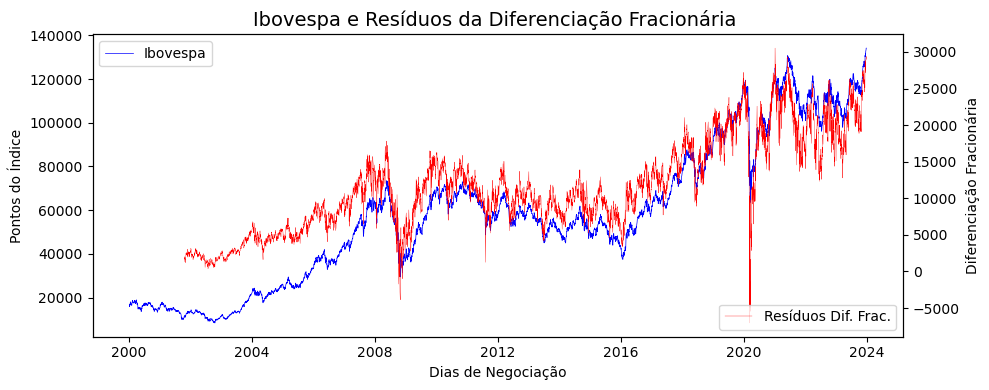

In [70]:
#===============================================================================================================================
# PRICE - TRANSF: FFD - PLOT: PRICES and RESIDUALS vs TIME
#===============================================================================================================================
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(data['Close']     , 'b-',  label='Ibovespa', linewidth=0.5)
ax1.legend(loc=2)
ax1.set_xlabel('Dias de Negociação')
ax1.set_ylabel('Pontos do Índice')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(fracdiff_residuals  , 'r', label='Resíduos Dif. Frac.', linewidth=0.25 ) #, linestyle='dotted')
ax2.set_ylabel('Diferenciação Fracionária')
ax2.legend(loc=4)

plt.title('Ibovespa e Resíduos da Diferenciação Fracionária ', fontsize=14)
#fig.autofmt_xdate()
plt.tight_layout()
#plt.show()

In [63]:
#===============================================================================================================================
# PRICE - TRANSF: OUTPUT
#===============================================================================================================================
fracdiff_residuals.to_csv('Data/Input/IBOV-FracDiff-Daily.csv')

In [64]:
#===============================================================================================================================
# PRICE - RECOVER: FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series,d,thres=THRESHOLD, w=None,series_ori=None):

    #---------------------------------------------------------------------------------------------------------------------------
    # Length of series
    #---------------------------------------------------------------------------------------------------------------------------
    length = len(series)
    
    #---------------------------------------------------------------------------------------------------------------------------
    # Width of w
    #---------------------------------------------------------------------------------------------------------------------------
    width=len(w)-1
    
    #---------------------------------------------------------------------------------------------------------------------------
    # Apply weights to values
    #---------------------------------------------------------------------------------------------------------------------------
    df= {}
    # seriesF (forward-filled) and df_ (empty series)
    #seriesF,df_=series.fillna(method='ffill').dropna(), pd.Series() 
    seriesF,df_=series, pd.Series() 
    
    print('width=',width, 'len(seriesF.index)=',len(seriesF.index))
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop seriesF
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,len(seriesF.index)):
        #-----------------------------------------------------------------------------------------------------------------------
        # First loc
        #-----------------------------------------------------------------------------------------------------------------------
        #loc0=seriesF.index[iloc1-width]
        #-----------------------------------------------------------------------------------------------------------------------
        # Last loc
        #-----------------------------------------------------------------------------------------------------------------------
        loc1=seriesF.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc1=', loc1)
        #-----------------------------------------------------------------------------------------------------------------------
        # Exclude NAs
        #-----------------------------------------------------------------------------------------------------------------------
        if not (np.isfinite(series.loc[loc1])).any():continue
        #-----------------------------------------------------------------------------------------------------------------------
        # Compute df_: Dot Product w x SeriesF[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        #df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0]
        #-----------------------------------------------------------------------------------------------------------------------
        # Compute df_: Recover
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        print('seriesF[loc1]=', seriesF.loc[loc1,'Residuals'])
        print('series_ori[loc1]=', series_ori.loc[loc1])
        print('w[iloc1]=', np.round(w[iloc1],6))

        df_[loc1] = np.round((seriesF.loc[loc1,'Residuals'] - (seriesF.loc[loc1,'Residuals']-series_ori.loc[loc1]*w[iloc1]))/w[iloc1],6)
    #---------------------------------------------------------------------------------------------------------------------------
    # Create residuals of the respective OHLC dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df['Close']=df_.copy(deep=True)
    #---------------------------------------------------------------------------------------------------------------------------
    # Convert the series into a dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df=pd.concat(df,axis=1)
    #print('len(df_)=', len(df_))
    #print(seriesF[-20:])
    #print(df_[-20:])

    return df

In [65]:
#===============================================================================================================================
# PRICE - RECOVER: WEIGHTS
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-446+1)
print(len(w_FFD))
#w_FFD

5497


In [66]:
#===============================================================================================================================
# PRICE - RECOVER: RESIDUALS
#===============================================================================================================================
fracdiff_recover = fracDiff_FFD_recover(fracdiff_residuals, d, THRESHOLD, w_FFD, data['Close'])


width= 5496 len(seriesF.index)= 5497


Loop: iloc1= 0  | loc1= 2001-10-18 00:00:00

seriesF[loc1]= 1352.1094690759628
series_ori[loc1]= 10994.96
w[iloc1]= [-4.e-06]

Loop: iloc1= 1  | loc1= 2001-10-19 00:00:00

seriesF[loc1]= 1738.2208820895503
series_ori[loc1]= 11331.57
w[iloc1]= [-4.e-06]

Loop: iloc1= 2  | loc1= 2001-10-22 00:00:00

seriesF[loc1]= 2036.1894150788776
series_ori[loc1]= 11699.99
w[iloc1]= [-4.e-06]

Loop: iloc1= 3  | loc1= 2001-10-23 00:00:00

seriesF[loc1]= 1833.354428637057
series_ori[loc1]= 11613.44
w[iloc1]= [-4.e-06]

Loop: iloc1= 4  | loc1= 2001-10-24 00:00:00

seriesF[loc1]= 1661.228960614133
series_ori[loc1]= 11467.74
w[iloc1]= [-4.e-06]

Loop: iloc1= 5  | loc1= 2001-10-25 00:00:00

seriesF[loc1]= 1933.075893063451
series_ori[loc1]= 11723.75
w[iloc1]= [-4.e-06]

Loop: iloc1= 6  | loc1= 2001-10-26 00:00:00

seriesF[loc1]= 1925.4897433110036
series_ori[loc1]= 11780.57
w[iloc1]= [-4.e-06]

Loop: iloc1= 7  | loc1= 2001-10-29 00:00:00

seriesF[loc1]= 1481.3703408464


Loop: iloc1= 189  | loc1= 2002-07-29 00:00:00

seriesF[loc1]= 581.3501345070981
series_ori[loc1]= 9240.47
w[iloc1]= [-5.e-06]

Loop: iloc1= 190  | loc1= 2002-07-30 00:00:00

seriesF[loc1]= 755.5475528567613
series_ori[loc1]= 9341.88
w[iloc1]= [-5.e-06]

Loop: iloc1= 191  | loc1= 2002-07-31 00:00:00

seriesF[loc1]= 1202.9220306628004
series_ori[loc1]= 9762.59
w[iloc1]= [-5.e-06]

Loop: iloc1= 192  | loc1= 2002-08-01 00:00:00

seriesF[loc1]= 1126.5987412323357
series_ori[loc1]= 9759.64
w[iloc1]= [-5.e-06]

Loop: iloc1= 193  | loc1= 2002-08-02 00:00:00

seriesF[loc1]= 1208.5053183105738
series_ori[loc1]= 9852.03
w[iloc1]= [-5.e-06]

Loop: iloc1= 194  | loc1= 2002-08-05 00:00:00

seriesF[loc1]= 805.6727137942689
series_ori[loc1]= 9469.84
w[iloc1]= [-5.e-06]

Loop: iloc1= 195  | loc1= 2002-08-06 00:00:00

seriesF[loc1]= 1184.0368069303286
series_ori[loc1]= 9755.08
w[iloc1]= [-5.e-06]

Loop: iloc1= 196  | loc1= 2002-08-07 00:00:00

seriesF[loc1]= 1266.8599538035396
series_ori[loc1]= 9869.6



Loop: iloc1= 276  | loc1= 2002-11-28 00:00:00

seriesF[loc1]= 1769.8067699859412
series_ori[loc1]= 10239.18
w[iloc1]= [-5.e-06]

Loop: iloc1= 277  | loc1= 2002-11-29 00:00:00

seriesF[loc1]= 2028.508261517366
series_ori[loc1]= 10508.81
w[iloc1]= [-5.e-06]

Loop: iloc1= 278  | loc1= 2002-12-02 00:00:00

seriesF[loc1]= 2119.930156759775
series_ori[loc1]= 10673.79
w[iloc1]= [-5.e-06]

Loop: iloc1= 279  | loc1= 2002-12-03 00:00:00

seriesF[loc1]= 2037.8947251514346
series_ori[loc1]= 10662.83
w[iloc1]= [-5.e-06]

Loop: iloc1= 280  | loc1= 2002-12-04 00:00:00

seriesF[loc1]= 1983.8494466317952
series_ori[loc1]= 10640.11
w[iloc1]= [-5.e-06]

Loop: iloc1= 281  | loc1= 2002-12-05 00:00:00

seriesF[loc1]= 1741.065305364069
series_ori[loc1]= 10413.09
w[iloc1]= [-5.e-06]

Loop: iloc1= 282  | loc1= 2002-12-06 00:00:00

seriesF[loc1]= 1939.5305446020702
series_ori[loc1]= 10569.02
w[iloc1]= [-5.e-06]

Loop: iloc1= 283  | loc1= 2002-12-09 00:00:00

seriesF[loc1]= 1680.2889827270155
series_ori[loc1]= 


Loop: iloc1= 345  | loc1= 2003-03-13 00:00:00

seriesF[loc1]= 2077.4824777245803
series_ori[loc1]= 10783.04
w[iloc1]= [-5.e-06]

Loop: iloc1= 346  | loc1= 2003-03-14 00:00:00

seriesF[loc1]= 2045.017443537895
series_ori[loc1]= 10817.36
w[iloc1]= [-5.e-06]

Loop: iloc1= 347  | loc1= 2003-03-17 00:00:00

seriesF[loc1]= 2066.195287622335
series_ori[loc1]= 10874.75
w[iloc1]= [-5.e-06]

Loop: iloc1= 348  | loc1= 2003-03-18 00:00:00

seriesF[loc1]= 2308.432568194252
series_ori[loc1]= 11150.99
w[iloc1]= [-5.e-06]

Loop: iloc1= 349  | loc1= 2003-03-19 00:00:00

seriesF[loc1]= 2076.6444904194914
series_ori[loc1]= 11006.39
w[iloc1]= [-5.e-06]

Loop: iloc1= 350  | loc1= 2003-03-20 00:00:00

seriesF[loc1]= 2226.6294421128114
series_ori[loc1]= 11158.98
w[iloc1]= [-5.e-06]

Loop: iloc1= 351  | loc1= 2003-03-21 00:00:00

seriesF[loc1]= 2396.0735150201
series_ori[loc1]= 11377.42
w[iloc1]= [-5.e-06]

Loop: iloc1= 352  | loc1= 2003-03-24 00:00:00

seriesF[loc1]= 1992.8176734389554
series_ori[loc1]= 110


seriesF[loc1]= 4175.949725424731
series_ori[loc1]= 18408.62
w[iloc1]= [-5.e-06]

Loop: iloc1= 514  | loc1= 2003-11-12 00:00:00

seriesF[loc1]= 4582.182295974808
series_ori[loc1]= 18793.54
w[iloc1]= [-5.e-06]

Loop: iloc1= 515  | loc1= 2003-11-13 00:00:00

seriesF[loc1]= 4444.017216677616
series_ori[loc1]= 18754.55
w[iloc1]= [-5.e-06]

Loop: iloc1= 516  | loc1= 2003-11-14 00:00:00

seriesF[loc1]= 4640.412280810491
series_ori[loc1]= 18985.87
w[iloc1]= [-5.e-06]

Loop: iloc1= 517  | loc1= 2003-11-17 00:00:00

seriesF[loc1]= 4238.128341071037
series_ori[loc1]= 18668.71
w[iloc1]= [-5.e-06]

Loop: iloc1= 518  | loc1= 2003-11-18 00:00:00

seriesF[loc1]= 4416.521957973397
series_ori[loc1]= 18812.97
w[iloc1]= [-5.e-06]

Loop: iloc1= 519  | loc1= 2003-11-19 00:00:00

seriesF[loc1]= 4371.846675088282
series_ori[loc1]= 18807.34
w[iloc1]= [-5.e-06]

Loop: iloc1= 520  | loc1= 2003-11-20 00:00:00

seriesF[loc1]= 4742.003634956014
series_ori[loc1]= 19199.14
w[iloc1]= [-5.e-06]

Loop: iloc1= 521  | lo


Loop: iloc1= 584  | loc1= 2004-02-26 00:00:00

seriesF[loc1]= 4376.027479762131
series_ori[loc1]= 21449.61
w[iloc1]= [-5.e-06]

Loop: iloc1= 585  | loc1= 2004-02-27 00:00:00

seriesF[loc1]= 4718.9307266399355
series_ori[loc1]= 21755.02
w[iloc1]= [-5.e-06]

Loop: iloc1= 586  | loc1= 2004-03-01 00:00:00

seriesF[loc1]= 5404.199102312135
series_ori[loc1]= 22498.59
w[iloc1]= [-5.e-06]

Loop: iloc1= 587  | loc1= 2004-03-02 00:00:00

seriesF[loc1]= 5146.555019691254
series_ori[loc1]= 22442.42
w[iloc1]= [-5.e-06]

Loop: iloc1= 588  | loc1= 2004-03-03 00:00:00

seriesF[loc1]= 5191.055827918819
series_ori[loc1]= 22550.49
w[iloc1]= [-5.e-06]

Loop: iloc1= 589  | loc1= 2004-03-04 00:00:00

seriesF[loc1]= 4966.273275954034
series_ori[loc1]= 22392.99
w[iloc1]= [-5.e-06]

Loop: iloc1= 590  | loc1= 2004-03-05 00:00:00

seriesF[loc1]= 5446.479659189847
series_ori[loc1]= 22872.94
w[iloc1]= [-5.e-06]

Loop: iloc1= 591  | loc1= 2004-03-08 00:00:00

seriesF[loc1]= 5434.135473103732
series_ori[loc1]= 2299


Loop: iloc1= 692  | loc1= 2004-08-02 00:00:00

seriesF[loc1]= 4936.353586386496
series_ori[loc1]= 22448.01
w[iloc1]= [-5.e-06]

Loop: iloc1= 693  | loc1= 2004-08-03 00:00:00

seriesF[loc1]= 4794.287635911369
series_ori[loc1]= 22372.9
w[iloc1]= [-5.e-06]

Loop: iloc1= 694  | loc1= 2004-08-04 00:00:00

seriesF[loc1]= 4578.5200499204275
series_ori[loc1]= 22177.92
w[iloc1]= [-5.e-06]

Loop: iloc1= 695  | loc1= 2004-08-05 00:00:00

seriesF[loc1]= 3756.7499421873435
series_ori[loc1]= 21330.25
w[iloc1]= [-5.e-06]

Loop: iloc1= 696  | loc1= 2004-08-06 00:00:00

seriesF[loc1]= 4288.035411630826
series_ori[loc1]= 21652.71
w[iloc1]= [-5.e-06]

Loop: iloc1= 697  | loc1= 2004-08-09 00:00:00

seriesF[loc1]= 3888.1147519966853
series_ori[loc1]= 21260.91
w[iloc1]= [-5.e-06]

Loop: iloc1= 698  | loc1= 2004-08-10 00:00:00

seriesF[loc1]= 4468.765623247056
series_ori[loc1]= 21736.72
w[iloc1]= [-5.e-06]

Loop: iloc1= 699  | loc1= 2004-08-11 00:00:00

seriesF[loc1]= 4225.282056492673
series_ori[loc1]= 215


Loop: iloc1= 756  | loc1= 2004-11-03 00:00:00

seriesF[loc1]= 5130.239310098295
series_ori[loc1]= 23660.11
w[iloc1]= [-5.e-06]

Loop: iloc1= 757  | loc1= 2004-11-04 00:00:00

seriesF[loc1]= 5225.959957323885
series_ori[loc1]= 23879.62
w[iloc1]= [-5.e-06]

Loop: iloc1= 758  | loc1= 2004-11-05 00:00:00

seriesF[loc1]= 4779.6516520906425
series_ori[loc1]= 23541.63
w[iloc1]= [-5.e-06]

Loop: iloc1= 759  | loc1= 2004-11-08 00:00:00

seriesF[loc1]= 4479.168497488465
series_ori[loc1]= 23211.89
w[iloc1]= [-5.e-06]

Loop: iloc1= 760  | loc1= 2004-11-09 00:00:00

seriesF[loc1]= 4559.486198255778
series_ori[loc1]= 23215.87
w[iloc1]= [-5.e-06]

Loop: iloc1= 761  | loc1= 2004-11-10 00:00:00

seriesF[loc1]= 4818.124234469775
series_ori[loc1]= 23454.55
w[iloc1]= [-5.e-06]

Loop: iloc1= 762  | loc1= 2004-11-11 00:00:00

seriesF[loc1]= 4832.350238093515
series_ori[loc1]= 23520.7
w[iloc1]= [-5.e-06]

Loop: iloc1= 763  | loc1= 2004-11-12 00:00:00

seriesF[loc1]= 5310.727988690267
series_ori[loc1]= 24035


Loop: iloc1= 850  | loc1= 2005-03-23 00:00:00

seriesF[loc1]= 4576.572736875505
series_ori[loc1]= 26248.27
w[iloc1]= [-5.e-06]

Loop: iloc1= 851  | loc1= 2005-03-24 00:00:00

seriesF[loc1]= 5210.899683880449
series_ori[loc1]= 26701.88
w[iloc1]= [-5.e-06]

Loop: iloc1= 852  | loc1= 2005-03-28 00:00:00

seriesF[loc1]= 4739.2841020453325
series_ori[loc1]= 26257.32
w[iloc1]= [-5.e-06]

Loop: iloc1= 853  | loc1= 2005-03-29 00:00:00

seriesF[loc1]= 4445.953430758826
series_ori[loc1]= 25842.08
w[iloc1]= [-5.e-06]

Loop: iloc1= 854  | loc1= 2005-03-30 00:00:00

seriesF[loc1]= 5231.133246201451
series_ori[loc1]= 26469.78
w[iloc1]= [-5.e-06]

Loop: iloc1= 855  | loc1= 2005-03-31 00:00:00

seriesF[loc1]= 5289.6455361724475
series_ori[loc1]= 26610.65
w[iloc1]= [-5.e-06]

Loop: iloc1= 856  | loc1= 2005-04-01 00:00:00

seriesF[loc1]= 5406.8338371896625
series_ori[loc1]= 26773.83
w[iloc1]= [-5.e-06]

Loop: iloc1= 857  | loc1= 2005-04-04 00:00:00

seriesF[loc1]= 4986.239831829025
series_ori[loc1]= 26


Loop: iloc1= 958  | loc1= 2005-08-25 00:00:00

seriesF[loc1]= 5825.330352214147
series_ori[loc1]= 27401.63
w[iloc1]= [-6.e-06]

Loop: iloc1= 959  | loc1= 2005-08-26 00:00:00

seriesF[loc1]= 5357.071017743994
series_ori[loc1]= 27094.61
w[iloc1]= [-6.e-06]

Loop: iloc1= 960  | loc1= 2005-08-29 00:00:00

seriesF[loc1]= 5662.5894109903675
series_ori[loc1]= 27384.83
w[iloc1]= [-6.e-06]

Loop: iloc1= 961  | loc1= 2005-08-30 00:00:00

seriesF[loc1]= 5800.7860268147415
series_ori[loc1]= 27603.74
w[iloc1]= [-6.e-06]

Loop: iloc1= 962  | loc1= 2005-08-31 00:00:00

seriesF[loc1]= 6149.911239885654
series_ori[loc1]= 28044.83
w[iloc1]= [-6.e-06]

Loop: iloc1= 963  | loc1= 2005-09-01 00:00:00

seriesF[loc1]= 5911.209673000978
series_ori[loc1]= 27962.19
w[iloc1]= [-6.e-06]

Loop: iloc1= 964  | loc1= 2005-09-02 00:00:00

seriesF[loc1]= 6215.006114406222
series_ori[loc1]= 28319.11
w[iloc1]= [-6.e-06]

Loop: iloc1= 965  | loc1= 2005-09-05 00:00:00

seriesF[loc1]= 6287.425364644163
series_ori[loc1]= 285


Loop: iloc1= 1022  | loc1= 2005-11-29 00:00:00

seriesF[loc1]= 6776.951544277905
series_ori[loc1]= 31651.55
w[iloc1]= [-6.e-06]

Loop: iloc1= 1023  | loc1= 2005-11-30 00:00:00

seriesF[loc1]= 6985.645207956404
series_ori[loc1]= 31916.76
w[iloc1]= [-6.e-06]

Loop: iloc1= 1024  | loc1= 2005-12-01 00:00:00

seriesF[loc1]= 7592.356879341467
series_ori[loc1]= 32617.18
w[iloc1]= [-6.e-06]

Loop: iloc1= 1025  | loc1= 2005-12-02 00:00:00

seriesF[loc1]= 7586.515248741442
series_ori[loc1]= 32832.45
w[iloc1]= [-6.e-06]

Loop: iloc1= 1026  | loc1= 2005-12-05 00:00:00

seriesF[loc1]= 7302.175833013458
series_ori[loc1]= 32701.17
w[iloc1]= [-6.e-06]

Loop: iloc1= 1027  | loc1= 2005-12-06 00:00:00

seriesF[loc1]= 7770.770175137299
series_ori[loc1]= 33223.42
w[iloc1]= [-6.e-06]

Loop: iloc1= 1028  | loc1= 2005-12-07 00:00:00

seriesF[loc1]= 7124.307657302568
series_ori[loc1]= 32756.79
w[iloc1]= [-6.e-06]

Loop: iloc1= 1029  | loc1= 2005-12-08 00:00:00

seriesF[loc1]= 6872.480030580042
series_ori[loc1


Loop: iloc1= 1160  | loc1= 2006-06-21 00:00:00

seriesF[loc1]= 6295.244535179932
series_ori[loc1]= 34546.64
w[iloc1]= [-6.e-06]

Loop: iloc1= 1161  | loc1= 2006-06-22 00:00:00

seriesF[loc1]= 5903.826837067587
series_ori[loc1]= 34316.77
w[iloc1]= [-6.e-06]

Loop: iloc1= 1162  | loc1= 2006-06-23 00:00:00

seriesF[loc1]= 6270.5923184962085
series_ori[loc1]= 34661.22
w[iloc1]= [-6.e-06]

Loop: iloc1= 1163  | loc1= 2006-06-26 00:00:00

seriesF[loc1]= 6168.862761758661
series_ori[loc1]= 34631.24
w[iloc1]= [-6.e-06]

Loop: iloc1= 1164  | loc1= 2006-06-27 00:00:00

seriesF[loc1]= 5903.439167442084
series_ori[loc1]= 34375.73
w[iloc1]= [-6.e-06]

Loop: iloc1= 1165  | loc1= 2006-06-28 00:00:00

seriesF[loc1]= 6425.032037741392
series_ori[loc1]= 34834.65
w[iloc1]= [-6.e-06]

Loop: iloc1= 1166  | loc1= 2006-06-29 00:00:00

seriesF[loc1]= 7990.489621663302
series_ori[loc1]= 36486.67
w[iloc1]= [-6.e-06]

Loop: iloc1= 1167  | loc1= 2006-06-30 00:00:00

seriesF[loc1]= 7700.7932742757475
series_ori[lo


Loop: iloc1= 1368  | loc1= 2007-04-25 00:00:00

seriesF[loc1]= 11351.485821331196
series_ori[loc1]= 49675.59
w[iloc1]= [-6.e-06]

Loop: iloc1= 1369  | loc1= 2007-04-26 00:00:00

seriesF[loc1]= 10544.011406428195
series_ori[loc1]= 49067.69
w[iloc1]= [-6.e-06]

Loop: iloc1= 1370  | loc1= 2007-04-27 00:00:00

seriesF[loc1]= 10753.955229958781
series_ori[loc1]= 49229.6
w[iloc1]= [-6.e-06]

Loop: iloc1= 1371  | loc1= 2007-04-30 00:00:00

seriesF[loc1]= 10421.255199630144
series_ori[loc1]= 48956.39
w[iloc1]= [-6.e-06]

Loop: iloc1= 1372  | loc1= 2007-05-02 00:00:00

seriesF[loc1]= 10959.901231316224
series_ori[loc1]= 49471.54
w[iloc1]= [-6.e-06]

Loop: iloc1= 1373  | loc1= 2007-05-03 00:00:00

seriesF[loc1]= 11564.191604165659
series_ori[loc1]= 50218.22
w[iloc1]= [-6.e-06]

Loop: iloc1= 1374  | loc1= 2007-05-04 00:00:00

seriesF[loc1]= 11688.227761865299
series_ori[loc1]= 50597.79
w[iloc1]= [-6.e-06]

Loop: iloc1= 1375  | loc1= 2007-05-07 00:00:00

seriesF[loc1]= 11156.030863264277
series_o


Loop: iloc1= 1575  | loc1= 2008-02-29 00:00:00

seriesF[loc1]= 12297.428985694569
series_ori[loc1]= 63489.3
w[iloc1]= [-7.e-06]

Loop: iloc1= 1576  | loc1= 2008-03-03 00:00:00

seriesF[loc1]= 13704.788594060628
series_ori[loc1]= 64490.46
w[iloc1]= [-7.e-06]

Loop: iloc1= 1577  | loc1= 2008-03-04 00:00:00

seriesF[loc1]= 12726.92152438892
series_ori[loc1]= 63655.54
w[iloc1]= [-7.e-06]

Loop: iloc1= 1578  | loc1= 2008-03-05 00:00:00

seriesF[loc1]= 13853.442241400633
series_ori[loc1]= 64629.48
w[iloc1]= [-7.e-06]

Loop: iloc1= 1579  | loc1= 2008-03-06 00:00:00

seriesF[loc1]= 11992.692694679434
series_ori[loc1]= 62974.65
w[iloc1]= [-7.e-06]

Loop: iloc1= 1580  | loc1= 2008-03-07 00:00:00

seriesF[loc1]= 11214.748651348782
series_ori[loc1]= 61867.99
w[iloc1]= [-7.e-06]

Loop: iloc1= 1581  | loc1= 2008-03-10 00:00:00

seriesF[loc1]= 9719.519272428559
series_ori[loc1]= 59999.27
w[iloc1]= [-7.e-06]

Loop: iloc1= 1582  | loc1= 2008-03-11 00:00:00

seriesF[loc1]= 12700.87599223989
series_ori[


Loop: iloc1= 1732  | loc1= 2008-10-14 00:00:00

seriesF[loc1]= 4298.241701471481
series_ori[loc1]= 41569.03
w[iloc1]= [-7.e-06]

Loop: iloc1= 1733  | loc1= 2008-10-15 00:00:00

seriesF[loc1]= -743.0307769679457
series_ori[loc1]= 36833.02
w[iloc1]= [-7.e-06]

Loop: iloc1= 1734  | loc1= 2008-10-16 00:00:00

seriesF[loc1]= -18.225829398790665
series_ori[loc1]= 36441.72
w[iloc1]= [-7.e-06]

Loop: iloc1= 1735  | loc1= 2008-10-17 00:00:00

seriesF[loc1]= 487.6510014985615
series_ori[loc1]= 36399.09
w[iloc1]= [-7.e-06]

Loop: iloc1= 1736  | loc1= 2008-10-20 00:00:00

seriesF[loc1]= 3871.5644079925514
series_ori[loc1]= 39441.08
w[iloc1]= [-7.e-06]

Loop: iloc1= 1737  | loc1= 2008-10-21 00:00:00

seriesF[loc1]= 2969.3623159962917
series_ori[loc1]= 39043.39
w[iloc1]= [-7.e-06]

Loop: iloc1= 1738  | loc1= 2008-10-22 00:00:00

seriesF[loc1]= -985.5931386458251
series_ori[loc1]= 35069.73
w[iloc1]= [-7.e-06]

Loop: iloc1= 1739  | loc1= 2008-10-23 00:00:00

seriesF[loc1]= -1204.620660524717
series_o


Loop: iloc1= 1846  | loc1= 2009-04-01 00:00:00

seriesF[loc1]= 7487.6054372957005
series_ori[loc1]= 41976.33
w[iloc1]= [-7.e-06]

Loop: iloc1= 1847  | loc1= 2009-04-02 00:00:00

seriesF[loc1]= 9002.811238328552
series_ori[loc1]= 43736.45
w[iloc1]= [-7.e-06]

Loop: iloc1= 1848  | loc1= 2009-04-03 00:00:00

seriesF[loc1]= 9130.407321016988
series_ori[loc1]= 44390.98
w[iloc1]= [-7.e-06]

Loop: iloc1= 1849  | loc1= 2009-04-06 00:00:00

seriesF[loc1]= 8526.863298339133
series_ori[loc1]= 44167.26
w[iloc1]= [-7.e-06]

Loop: iloc1= 1850  | loc1= 2009-04-07 00:00:00

seriesF[loc1]= 8045.601839558374
series_ori[loc1]= 43824.53
w[iloc1]= [-7.e-06]

Loop: iloc1= 1851  | loc1= 2009-04-08 00:00:00

seriesF[loc1]= 8379.093101092512
series_ori[loc1]= 44181.98
w[iloc1]= [-7.e-06]

Loop: iloc1= 1852  | loc1= 2009-04-09 00:00:00

seriesF[loc1]= 9594.384527559909
series_ori[loc1]= 45538.71
w[iloc1]= [-7.e-06]

Loop: iloc1= 1853  | loc1= 2009-04-13 00:00:00

seriesF[loc1]= 9627.623618372658
series_ori[loc


Loop: iloc1= 2002  | loc1= 2009-11-17 00:00:00

seriesF[loc1]= 15757.830069675845
series_ori[loc1]= 67405.98
w[iloc1]= [-8.e-06]

Loop: iloc1= 2003  | loc1= 2009-11-18 00:00:00

seriesF[loc1]= 14510.218586412448
series_ori[loc1]= 66515.66
w[iloc1]= [-8.e-06]

Loop: iloc1= 2004  | loc1= 2009-11-19 00:00:00

seriesF[loc1]= 14361.881124032996
series_ori[loc1]= 66327.28
w[iloc1]= [-8.e-06]

Loop: iloc1= 2005  | loc1= 2009-11-23 00:00:00

seriesF[loc1]= 14847.766814145172
series_ori[loc1]= 66809.4
w[iloc1]= [-8.e-06]

Loop: iloc1= 2006  | loc1= 2009-11-24 00:00:00

seriesF[loc1]= 15203.099155549025
series_ori[loc1]= 67317.0
w[iloc1]= [-8.e-06]

Loop: iloc1= 2007  | loc1= 2009-11-25 00:00:00

seriesF[loc1]= 15593.8040035218
series_ori[loc1]= 67917.08
w[iloc1]= [-8.e-06]

Loop: iloc1= 2008  | loc1= 2009-11-26 00:00:00

seriesF[loc1]= 13807.392709127416
series_ori[loc1]= 66391.8
w[iloc1]= [-8.e-06]

Loop: iloc1= 2009  | loc1= 2009-11-27 00:00:00

seriesF[loc1]= 14737.967844111809
series_ori[l


Loop: iloc1= 2167  | loc1= 2010-07-22 00:00:00

seriesF[loc1]= 13768.531200318706
series_ori[loc1]= 65748.1
w[iloc1]= [-8.e-06]

Loop: iloc1= 2168  | loc1= 2010-07-23 00:00:00

seriesF[loc1]= 13950.590091557213
series_ori[loc1]= 66322.99
w[iloc1]= [-8.e-06]

Loop: iloc1= 2169  | loc1= 2010-07-26 00:00:00

seriesF[loc1]= 13756.616835876404
series_ori[loc1]= 66443.26
w[iloc1]= [-8.e-06]

Loop: iloc1= 2170  | loc1= 2010-07-27 00:00:00

seriesF[loc1]= 13795.443621241233
series_ori[loc1]= 66674.44
w[iloc1]= [-8.e-06]

Loop: iloc1= 2171  | loc1= 2010-07-28 00:00:00

seriesF[loc1]= 13749.958998470749
series_ori[loc1]= 66808.25
w[iloc1]= [-8.e-06]

Loop: iloc1= 2172  | loc1= 2010-07-29 00:00:00

seriesF[loc1]= 13750.647901205462
series_ori[loc1]= 66953.83
w[iloc1]= [-8.e-06]

Loop: iloc1= 2173  | loc1= 2010-07-30 00:00:00

seriesF[loc1]= 14179.541909999702
series_ori[loc1]= 67515.4
w[iloc1]= [-8.e-06]

Loop: iloc1= 2174  | loc1= 2010-08-02 00:00:00

seriesF[loc1]= 14953.450497615268
series_or


Loop: iloc1= 2307  | loc1= 2011-02-14 00:00:00

seriesF[loc1]= 12147.988089837003
series_ori[loc1]= 66557.55
w[iloc1]= [-9.e-06]

Loop: iloc1= 2308  | loc1= 2011-02-15 00:00:00

seriesF[loc1]= 11697.225659852105
series_ori[loc1]= 66341.39
w[iloc1]= [-9.e-06]

Loop: iloc1= 2309  | loc1= 2011-02-16 00:00:00

seriesF[loc1]= 12909.115786943607
series_ori[loc1]= 67576.62
w[iloc1]= [-9.e-06]

Loop: iloc1= 2310  | loc1= 2011-02-17 00:00:00

seriesF[loc1]= 12695.663006556919
series_ori[loc1]= 67684.99
w[iloc1]= [-9.e-06]

Loop: iloc1= 2311  | loc1= 2011-02-18 00:00:00

seriesF[loc1]= 12929.762464127547
series_ori[loc1]= 68066.82
w[iloc1]= [-9.e-06]

Loop: iloc1= 2312  | loc1= 2011-02-21 00:00:00

seriesF[loc1]= 11949.016174362529
series_ori[loc1]= 67258.66
w[iloc1]= [-9.e-06]

Loop: iloc1= 2313  | loc1= 2011-02-22 00:00:00

seriesF[loc1]= 11246.097595710147
series_ori[loc1]= 66439.83
w[iloc1]= [-9.e-06]

Loop: iloc1= 2314  | loc1= 2011-02-23 00:00:00

seriesF[loc1]= 11940.65924374992
series_o


Loop: iloc1= 2432  | loc1= 2011-08-15 00:00:00

seriesF[loc1]= 8249.450191623495
series_ori[loc1]= 54651.83
w[iloc1]= [-9.e-06]

Loop: iloc1= 2433  | loc1= 2011-08-16 00:00:00

seriesF[loc1]= 7628.506451660865
series_ori[loc1]= 54323.61
w[iloc1]= [-9.e-06]

Loop: iloc1= 2434  | loc1= 2011-08-17 00:00:00

seriesF[loc1]= 8376.028845448564
series_ori[loc1]= 55073.02
w[iloc1]= [-9.e-06]

Loop: iloc1= 2435  | loc1= 2011-08-18 00:00:00

seriesF[loc1]= 6253.985703206381
series_ori[loc1]= 53134.1
w[iloc1]= [-9.e-06]

Loop: iloc1= 2436  | loc1= 2011-08-19 00:00:00

seriesF[loc1]= 5993.459732968062
series_ori[loc1]= 52447.63
w[iloc1]= [-9.e-06]

Loop: iloc1= 2437  | loc1= 2011-08-22 00:00:00

seriesF[loc1]= 6317.900239454164
series_ori[loc1]= 52440.23
w[iloc1]= [-9.e-06]

Loop: iloc1= 2438  | loc1= 2011-08-23 00:00:00

seriesF[loc1]= 7832.298468447254
series_ori[loc1]= 53786.63
w[iloc1]= [-9.e-06]

Loop: iloc1= 2439  | loc1= 2011-08-24 00:00:00

seriesF[loc1]= 7622.976986025711
series_ori[loc1]


Loop: iloc1= 2583  | loc1= 2012-03-23 00:00:00

seriesF[loc1]= 12196.625608618844
series_ori[loc1]= 65812.95
w[iloc1]= [-1.e-05]

Loop: iloc1= 2584  | loc1= 2012-03-26 00:00:00

seriesF[loc1]= 13175.859622687196
series_ori[loc1]= 66684.59
w[iloc1]= [-1.e-05]

Loop: iloc1= 2585  | loc1= 2012-03-27 00:00:00

seriesF[loc1]= 12368.01881164842
series_ori[loc1]= 66037.35
w[iloc1]= [-1.e-05]

Loop: iloc1= 2586  | loc1= 2012-03-28 00:00:00

seriesF[loc1]= 11522.645937287314
series_ori[loc1]= 65079.34
w[iloc1]= [-1.e-05]

Loop: iloc1= 2587  | loc1= 2012-03-29 00:00:00

seriesF[loc1]= 11586.924928952052
series_ori[loc1]= 64871.99
w[iloc1]= [-1.e-05]

Loop: iloc1= 2588  | loc1= 2012-03-30 00:00:00

seriesF[loc1]= 11382.532743253658
series_ori[loc1]= 64510.97
w[iloc1]= [-1.e-05]

Loop: iloc1= 2589  | loc1= 2012-04-02 00:00:00

seriesF[loc1]= 12256.883757818105
series_ori[loc1]= 65216.25
w[iloc1]= [-1.e-05]

Loop: iloc1= 2590  | loc1= 2012-04-03 00:00:00

seriesF[loc1]= 11233.872131212833
series_o


Loop: iloc1= 2735  | loc1= 2012-10-31 00:00:00

seriesF[loc1]= 9311.807964541826
series_ori[loc1]= 57068.18
w[iloc1]= [-1.e-05]

Loop: iloc1= 2736  | loc1= 2012-11-01 00:00:00

seriesF[loc1]= 10779.963639774327
series_ori[loc1]= 58382.68
w[iloc1]= [-1.e-05]

Loop: iloc1= 2737  | loc1= 2012-11-05 00:00:00

seriesF[loc1]= 10348.72800648459
series_ori[loc1]= 58209.76
w[iloc1]= [-1.e-05]

Loop: iloc1= 2738  | loc1= 2012-11-06 00:00:00

seriesF[loc1]= 11564.44385967982
series_ori[loc1]= 59458.59
w[iloc1]= [-1.e-05]

Loop: iloc1= 2739  | loc1= 2012-11-07 00:00:00

seriesF[loc1]= 10293.652141721497
series_ori[loc1]= 58517.35
w[iloc1]= [-1.e-05]

Loop: iloc1= 2740  | loc1= 2012-11-08 00:00:00

seriesF[loc1]= 9408.21813971068
series_ori[loc1]= 57524.45
w[iloc1]= [-1.e-05]

Loop: iloc1= 2741  | loc1= 2012-11-09 00:00:00

seriesF[loc1]= 9503.160805333522
series_ori[loc1]= 57357.71
w[iloc1]= [-1.e-05]

Loop: iloc1= 2742  | loc1= 2012-11-12 00:00:00

seriesF[loc1]= 9346.329174528382
series_ori[loc


Loop: iloc1= 2860  | loc1= 2013-05-10 00:00:00

seriesF[loc1]= 9145.028835259567
series_ori[loc1]= 55107.8
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2861  | loc1= 2013-05-13 00:00:00

seriesF[loc1]= 8594.555092187096
series_ori[loc1]= 54447.77
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2862  | loc1= 2013-05-14 00:00:00

seriesF[loc1]= 9021.763055808755
series_ori[loc1]= 54666.82
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2863  | loc1= 2013-05-15 00:00:00

seriesF[loc1]= 9324.836346787517
series_ori[loc1]= 54936.41
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2864  | loc1= 2013-05-16 00:00:00

seriesF[loc1]= 9128.004626869362
series_ori[loc1]= 54772.62
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2865  | loc1= 2013-05-17 00:00:00

seriesF[loc1]= 9562.16475158355
series_ori[loc1]= 55164.27
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2866  | loc1= 2013-05-20 00:00:00

seriesF[loc1]= 10023.843510201277
series_ori[loc1]= 55700.77
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2867  | loc1= 2013-05-21 00:00:00

seriesF[loc1]= 10435.820651400136
series_o


Loop: iloc1= 2989  | loc1= 2013-11-11 00:00:00

seriesF[loc1]= 8826.717363909615
series_ori[loc1]= 52623.87
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2990  | loc1= 2013-11-12 00:00:00

seriesF[loc1]= 8024.9858400664525
series_ori[loc1]= 51804.33
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2991  | loc1= 2013-11-13 00:00:00

seriesF[loc1]= 8693.192262514443
series_ori[loc1]= 52230.29
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2992  | loc1= 2013-11-14 00:00:00

seriesF[loc1]= 9919.141895716235
series_ori[loc1]= 53451.6
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2993  | loc1= 2013-11-18 00:00:00

seriesF[loc1]= 10504.60892832595
series_ori[loc1]= 54307.04
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2994  | loc1= 2013-11-19 00:00:00

seriesF[loc1]= 8935.655382569166
series_ori[loc1]= 53032.91
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2995  | loc1= 2013-11-21 00:00:00

seriesF[loc1]= 8788.99947580872
series_ori[loc1]= 52688.02
w[iloc1]= [-1.2e-05]

Loop: iloc1= 2996  | loc1= 2013-11-22 00:00:00

seriesF[loc1]= 9038.4913787031
series_ori[


Loop: iloc1= 3121  | loc1= 2014-05-29 00:00:00

seriesF[loc1]= 9288.348241482308
series_ori[loc1]= 52239.34
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3122  | loc1= 2014-05-30 00:00:00

seriesF[loc1]= 8375.353533535374
series_ori[loc1]= 51239.34
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3123  | loc1= 2014-06-02 00:00:00

seriesF[loc1]= 9021.99044961165
series_ori[loc1]= 51605.83
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3124  | loc1= 2014-06-03 00:00:00

seriesF[loc1]= 9468.790938881299
series_ori[loc1]= 52032.38
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3125  | loc1= 2014-06-04 00:00:00

seriesF[loc1]= 9195.320189716891
series_ori[loc1]= 51832.98
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3126  | loc1= 2014-06-05 00:00:00

seriesF[loc1]= 8956.443491162998
series_ori[loc1]= 51558.79
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3127  | loc1= 2014-06-06 00:00:00

seriesF[loc1]= 10609.938376939303
series_ori[loc1]= 53128.66
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3128  | loc1= 2014-06-09 00:00:00

seriesF[loc1]= 11400.79582100163
series_o


Loop: iloc1= 3255  | loc1= 2014-12-09 00:00:00

seriesF[loc1]= 7282.46030849035
series_ori[loc1]= 50193.47
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3256  | loc1= 2014-12-10 00:00:00

seriesF[loc1]= 6853.090323149016
series_ori[loc1]= 49548.08
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3257  | loc1= 2014-12-11 00:00:00

seriesF[loc1]= 7460.4277184766615
series_ori[loc1]= 49861.81
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3258  | loc1= 2014-12-12 00:00:00

seriesF[loc1]= 5680.121186691722
series_ori[loc1]= 48001.98
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3259  | loc1= 2014-12-15 00:00:00

seriesF[loc1]= 5241.425571215361
series_ori[loc1]= 47018.68
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3260  | loc1= 2014-12-16 00:00:00

seriesF[loc1]= 5718.414825663374
series_ori[loc1]= 47007.51
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3261  | loc1= 2014-12-17 00:00:00

seriesF[loc1]= 7680.40916181785
series_ori[loc1]= 48713.64
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3262  | loc1= 2014-12-18 00:00:00

seriesF[loc1]= 7215.05147939032
series_ori


Loop: iloc1= 3321  | loc1= 2015-03-19 00:00:00

seriesF[loc1]= 9375.356858434556
series_ori[loc1]= 50953.53
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3322  | loc1= 2015-03-20 00:00:00

seriesF[loc1]= 10357.445526100855
series_ori[loc1]= 51966.58
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3323  | loc1= 2015-03-23 00:00:00

seriesF[loc1]= 9998.60914319972
series_ori[loc1]= 51908.46
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3324  | loc1= 2015-03-24 00:00:00

seriesF[loc1]= 9477.570873717006
series_ori[loc1]= 51506.07
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3325  | loc1= 2015-03-25 00:00:00

seriesF[loc1]= 9850.28660452615
series_ori[loc1]= 51858.3
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3326  | loc1= 2015-03-26 00:00:00

seriesF[loc1]= 8463.537288413714
series_ori[loc1]= 50579.85
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3327  | loc1= 2015-03-27 00:00:00

seriesF[loc1]= 8239.776833621327
series_ori[loc1]= 50094.66
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3328  | loc1= 2015-03-30 00:00:00

seriesF[loc1]= 9587.698945629636
series_ori


Loop: iloc1= 3427  | loc1= 2015-08-21 00:00:00

seriesF[loc1]= 5691.915996702937
series_ori[loc1]= 45719.64
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3428  | loc1= 2015-08-24 00:00:00

seriesF[loc1]= 4631.160412103149
series_ori[loc1]= 44336.47
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3429  | loc1= 2015-08-25 00:00:00

seriesF[loc1]= 5343.477761643069
series_ori[loc1]= 44544.85
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3430  | loc1= 2015-08-26 00:00:00

seriesF[loc1]= 7026.530415016277
series_ori[loc1]= 46038.07
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3431  | loc1= 2015-08-27 00:00:00

seriesF[loc1]= 8477.09293416546
series_ori[loc1]= 47715.27
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3432  | loc1= 2015-08-28 00:00:00

seriesF[loc1]= 7473.532608503214
series_ori[loc1]= 47153.86
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3433  | loc1= 2015-08-31 00:00:00

seriesF[loc1]= 6941.033920215617
series_ori[loc1]= 46625.52
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3434  | loc1= 2015-09-01 00:00:00

seriesF[loc1]= 5909.393709403001
series_or


Loop: iloc1= 3506  | loc1= 2015-12-16 00:00:00

seriesF[loc1]= 7034.442875290679
series_ori[loc1]= 45015.84
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3507  | loc1= 2015-12-17 00:00:00

seriesF[loc1]= 7285.733752786175
series_ori[loc1]= 45261.47
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3508  | loc1= 2015-12-18 00:00:00

seriesF[loc1]= 5894.288472743749
series_ori[loc1]= 43910.59
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3509  | loc1= 2015-12-21 00:00:00

seriesF[loc1]= 5517.269055966717
series_ori[loc1]= 43199.95
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3510  | loc1= 2015-12-22 00:00:00

seriesF[loc1]= 6095.781166850029
series_ori[loc1]= 43469.51
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3511  | loc1= 2015-12-23 00:00:00

seriesF[loc1]= 6723.289178304316
series_ori[loc1]= 44014.93
w[iloc1]= [-1.6e-05]

Loop: iloc1= 3512  | loc1= 2015-12-28 00:00:00

seriesF[loc1]= 6411.393874852845
series_ori[loc1]= 43764.33
w[iloc1]= [-1.6e-05]

Loop: iloc1= 3513  | loc1= 2015-12-29 00:00:00

seriesF[loc1]= 6372.5805484476405
series_


Loop: iloc1= 3611  | loc1= 2016-05-24 00:00:00

seriesF[loc1]= 8389.978196204218
series_ori[loc1]= 49345.18
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3612  | loc1= 2016-05-25 00:00:00

seriesF[loc1]= 8627.961334278974
series_ori[loc1]= 49482.85
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3613  | loc1= 2016-05-27 00:00:00

seriesF[loc1]= 8231.852149362614
series_ori[loc1]= 49051.49
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3614  | loc1= 2016-05-30 00:00:00

seriesF[loc1]= 8291.22608305763
series_ori[loc1]= 48964.34
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3615  | loc1= 2016-05-31 00:00:00

seriesF[loc1]= 7894.068640941201
series_ori[loc1]= 48471.7
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3616  | loc1= 2016-06-01 00:00:00

seriesF[loc1]= 8617.1915168177
series_ori[loc1]= 49012.65
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3617  | loc1= 2016-06-02 00:00:00

seriesF[loc1]= 9448.096048659783
series_ori[loc1]= 49887.24
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3618  | loc1= 2016-06-03 00:00:00

seriesF[loc1]= 9975.033418149462
series_ori[l


Loop: iloc1= 3704  | loc1= 2016-10-04 00:00:00

seriesF[loc1]= 12302.866199089149
series_ori[loc1]= 59339.22
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3705  | loc1= 2016-10-05 00:00:00

seriesF[loc1]= 13140.616785624825
series_ori[loc1]= 60254.34
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3706  | loc1= 2016-10-06 00:00:00

seriesF[loc1]= 13246.556953799743
series_ori[loc1]= 60644.24
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3707  | loc1= 2016-10-07 00:00:00

seriesF[loc1]= 13485.04025985342
series_ori[loc1]= 61108.98
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3708  | loc1= 2016-10-10 00:00:00

seriesF[loc1]= 13806.43986231343
series_ori[loc1]= 61668.33
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3709  | loc1= 2016-10-11 00:00:00

seriesF[loc1]= 12890.795981251344
series_ori[loc1]= 61021.84
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3710  | loc1= 2016-10-13 00:00:00

seriesF[loc1]= 13002.731131430657
series_ori[loc1]= 61118.58
w[iloc1]= [-1.8e-05]

Loop: iloc1= 3711  | loc1= 2016-10-14 00:00:00

seriesF[loc1]= 13583.583954519745
se


Loop: iloc1= 3792  | loc1= 2017-02-10 00:00:00

seriesF[loc1]= 14581.650167978027
series_ori[loc1]= 66124.52
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3793  | loc1= 2017-02-13 00:00:00

seriesF[loc1]= 15082.717696458705
series_ori[loc1]= 66967.64
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3794  | loc1= 2017-02-14 00:00:00

seriesF[loc1]= 14470.070067610679
series_ori[loc1]= 66712.88
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3795  | loc1= 2017-02-15 00:00:00

seriesF[loc1]= 15620.874328637598
series_ori[loc1]= 67975.58
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3796  | loc1= 2017-02-16 00:00:00

seriesF[loc1]= 15051.082422844454
series_ori[loc1]= 67814.24
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3797  | loc1= 2017-02-17 00:00:00

seriesF[loc1]= 14831.018032451626
series_ori[loc1]= 67748.41
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3798  | loc1= 2017-02-20 00:00:00

seriesF[loc1]= 15514.126701080218
series_ori[loc1]= 68532.85
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3799  | loc1= 2017-02-21 00:00:00

seriesF[loc1]= 15750.729468250931



Loop: iloc1= 3894  | loc1= 2017-07-12 00:00:00

seriesF[loc1]= 13460.766443723536
series_ori[loc1]= 64835.55
w[iloc1]= [-2.e-05]

Loop: iloc1= 3895  | loc1= 2017-07-13 00:00:00

seriesF[loc1]= 13451.841338924372
series_ori[loc1]= 65178.34
w[iloc1]= [-2.e-05]

Loop: iloc1= 3896  | loc1= 2017-07-14 00:00:00

seriesF[loc1]= 13468.073003983824
series_ori[loc1]= 65436.17
w[iloc1]= [-2.e-05]

Loop: iloc1= 3897  | loc1= 2017-07-17 00:00:00

seriesF[loc1]= 13048.859213836506
series_ori[loc1]= 65212.31
w[iloc1]= [-2.e-05]

Loop: iloc1= 3898  | loc1= 2017-07-18 00:00:00

seriesF[loc1]= 13115.09531389214
series_ori[loc1]= 65337.66
w[iloc1]= [-2.e-05]

Loop: iloc1= 3899  | loc1= 2017-07-19 00:00:00

seriesF[loc1]= 12864.074787141064
series_ori[loc1]= 65179.92
w[iloc1]= [-2.e-05]

Loop: iloc1= 3900  | loc1= 2017-07-20 00:00:00

seriesF[loc1]= 12596.832974041863
series_ori[loc1]= 64938.01
w[iloc1]= [-2.e-05]

Loop: iloc1= 3901  | loc1= 2017-07-21 00:00:00

seriesF[loc1]= 12366.165200736817
series_o


Loop: iloc1= 3987  | loc1= 2017-11-27 00:00:00

seriesF[loc1]= 14543.561726187858
series_ori[loc1]= 74058.92
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3988  | loc1= 2017-11-28 00:00:00

seriesF[loc1]= 14634.81826466482
series_ori[loc1]= 74139.72
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3989  | loc1= 2017-11-29 00:00:00

seriesF[loc1]= 13166.348225348287
series_ori[loc1]= 72700.45
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3990  | loc1= 2017-11-30 00:00:00

seriesF[loc1]= 12774.230333286636
series_ori[loc1]= 71970.99
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3991  | loc1= 2017-12-01 00:00:00

seriesF[loc1]= 13365.4927965713
series_ori[loc1]= 72264.45
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3992  | loc1= 2017-12-04 00:00:00

seriesF[loc1]= 14248.443549426207
series_ori[loc1]= 73090.17
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3993  | loc1= 2017-12-05 00:00:00

seriesF[loc1]= 13550.25839352885
series_ori[loc1]= 72546.17
w[iloc1]= [-2.2e-05]

Loop: iloc1= 3994  | loc1= 2017-12-06 00:00:00

seriesF[loc1]= 14368.0637700695
series


Loop: iloc1= 4077  | loc1= 2018-04-11 00:00:00

seriesF[loc1]= 17709.179203733947
series_ori[loc1]= 85245.59
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4078  | loc1= 2018-04-12 00:00:00

seriesF[loc1]= 17675.961541307362
series_ori[loc1]= 85443.53
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4079  | loc1= 2018-04-13 00:00:00

seriesF[loc1]= 16421.9779237115
series_ori[loc1]= 84334.41
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4080  | loc1= 2018-04-16 00:00:00

seriesF[loc1]= 15145.719775938152
series_ori[loc1]= 82861.58
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4081  | loc1= 2018-04-17 00:00:00

seriesF[loc1]= 16783.692287744685
series_ori[loc1]= 84086.13
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4082  | loc1= 2018-04-18 00:00:00

seriesF[loc1]= 18323.286185184326
series_ori[loc1]= 85776.46
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4083  | loc1= 2018-04-19 00:00:00

seriesF[loc1]= 17921.201201640783
series_ori[loc1]= 85824.26
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4084  | loc1= 2018-04-20 00:00:00

seriesF[loc1]= 17464.250603777116
se


Loop: iloc1= 4185  | loc1= 2018-09-14 00:00:00

seriesF[loc1]= 13330.451307631884
series_ori[loc1]= 75429.1
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4186  | loc1= 2018-09-17 00:00:00

seriesF[loc1]= 14585.827847612636
series_ori[loc1]= 76788.86
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4187  | loc1= 2018-09-18 00:00:00

seriesF[loc1]= 15760.032552258359
series_ori[loc1]= 78313.97
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4188  | loc1= 2018-09-19 00:00:00

seriesF[loc1]= 15111.942527236999
series_ori[loc1]= 78168.66
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4189  | loc1= 2018-09-20 00:00:00

seriesF[loc1]= 14886.913864382695
series_ori[loc1]= 78116.02
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4190  | loc1= 2018-09-21 00:00:00

seriesF[loc1]= 16116.970463098223
series_ori[loc1]= 79444.29
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4191  | loc1= 2018-09-24 00:00:00

seriesF[loc1]= 14253.81864511883
series_ori[loc1]= 77984.19
w[iloc1]= [-2.6e-05]

Loop: iloc1= 4192  | loc1= 2018-09-25 00:00:00

seriesF[loc1]= 15083.092361532676
se


Loop: iloc1= 4266  | loc1= 2019-01-17 00:00:00

seriesF[loc1]= 21299.71197027871
series_ori[loc1]= 95351.09
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4267  | loc1= 2019-01-18 00:00:00

seriesF[loc1]= 21675.534178482325
series_ori[loc1]= 96096.75
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4268  | loc1= 2019-01-21 00:00:00

seriesF[loc1]= 21205.700792769654
series_ori[loc1]= 96009.78
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4269  | loc1= 2019-01-22 00:00:00

seriesF[loc1]= 20105.562123921904
series_ori[loc1]= 95103.38
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4270  | loc1= 2019-01-23 00:00:00

seriesF[loc1]= 21634.467475318743
series_ori[loc1]= 96558.43
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4271  | loc1= 2019-01-24 00:00:00

seriesF[loc1]= 22351.241778615404
series_ori[loc1]= 97677.2
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4272  | loc1= 2019-01-28 00:00:00

seriesF[loc1]= 19645.986010759792
series_ori[loc1]= 95443.88
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4273  | loc1= 2019-01-29 00:00:00

seriesF[loc1]= 20151.89997248295
ser


Loop: iloc1= 4385  | loc1= 2019-07-12 00:00:00

seriesF[loc1]= 21268.523086139947
series_ori[loc1]= 103905.99
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4386  | loc1= 2019-07-15 00:00:00

seriesF[loc1]= 21345.738491803408
series_ori[loc1]= 103802.69
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4387  | loc1= 2019-07-16 00:00:00

seriesF[loc1]= 21346.327515464814
series_ori[loc1]= 103775.41
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4388  | loc1= 2019-07-17 00:00:00

seriesF[loc1]= 21410.49989163704
series_ori[loc1]= 103855.53
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4389  | loc1= 2019-07-18 00:00:00

seriesF[loc1]= 22217.38495433703
series_ori[loc1]= 104716.59
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4390  | loc1= 2019-07-19 00:00:00

seriesF[loc1]= 20691.435857368284
series_ori[loc1]= 103451.93
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4391  | loc1= 2019-07-22 00:00:00

seriesF[loc1]= 21377.106745421188
series_ori[loc1]= 103949.46
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4392  | loc1= 2019-07-23 00:00:00

seriesF[loc1]= 21035.22686964


Loop: iloc1= 4463  | loc1= 2019-10-30 00:00:00

seriesF[loc1]= 22730.330350153643
series_ori[loc1]= 108407.54
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4464  | loc1= 2019-10-31 00:00:00

seriesF[loc1]= 21271.64510039157
series_ori[loc1]= 107219.83
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4465  | loc1= 2019-11-01 00:00:00

seriesF[loc1]= 22402.361000302844
series_ori[loc1]= 108195.63
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4466  | loc1= 2019-11-04 00:00:00

seriesF[loc1]= 22751.266865683618
series_ori[loc1]= 108779.33
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4467  | loc1= 2019-11-05 00:00:00

seriesF[loc1]= 22435.186899584623
series_ori[loc1]= 108719.02
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4468  | loc1= 2019-11-06 00:00:00

seriesF[loc1]= 21955.962267118906
series_ori[loc1]= 108360.22
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4469  | loc1= 2019-11-07 00:00:00

seriesF[loc1]= 23172.32530740196
series_ori[loc1]= 109580.57
w[iloc1]= [-3.5e-05]

Loop: iloc1= 4470  | loc1= 2019-11-08 00:00:00

seriesF[loc1]= 20874.06214007


Loop: iloc1= 4568  | loc1= 2020-04-06 00:00:00

seriesF[loc1]= 8250.094411684426
series_ori[loc1]= 74072.98
w[iloc1]= [-4.e-05]

Loop: iloc1= 4569  | loc1= 2020-04-07 00:00:00

seriesF[loc1]= 9844.675793658571
series_ori[loc1]= 76358.09
w[iloc1]= [-4.e-05]

Loop: iloc1= 4570  | loc1= 2020-04-08 00:00:00

seriesF[loc1]= 11440.181584292368
series_ori[loc1]= 78624.62
w[iloc1]= [-4.e-05]

Loop: iloc1= 4571  | loc1= 2020-04-09 00:00:00

seriesF[loc1]= 9737.235277778353
series_ori[loc1]= 77681.94
w[iloc1]= [-4.e-05]

Loop: iloc1= 4572  | loc1= 2020-04-13 00:00:00

seriesF[loc1]= 10847.595253196567
series_ori[loc1]= 78835.82
w[iloc1]= [-4.e-05]

Loop: iloc1= 4573  | loc1= 2020-04-14 00:00:00

seriesF[loc1]= 11598.252661461738
series_ori[loc1]= 79918.36
w[iloc1]= [-4.e-05]

Loop: iloc1= 4574  | loc1= 2020-04-15 00:00:00

seriesF[loc1]= 10120.785819738361
series_ori[loc1]= 78831.46
w[iloc1]= [-4.e-05]

Loop: iloc1= 4575  | loc1= 2020-04-16 00:00:00

seriesF[loc1]= 9215.27291544556
series_ori[l


Loop: iloc1= 4657  | loc1= 2020-08-13 00:00:00

seriesF[loc1]= 17774.096196727107
series_ori[loc1]= 100460.6
w[iloc1]= [-4.5e-05]

Loop: iloc1= 4658  | loc1= 2020-08-14 00:00:00

seriesF[loc1]= 19105.00551260126
series_ori[loc1]= 101353.45
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4659  | loc1= 2020-08-17 00:00:00

seriesF[loc1]= 17286.87686586468
series_ori[loc1]= 99595.41
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4660  | loc1= 2020-08-18 00:00:00

seriesF[loc1]= 20198.367139825496
series_ori[loc1]= 102065.35
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4661  | loc1= 2020-08-19 00:00:00

seriesF[loc1]= 18543.12125392152
series_ori[loc1]= 100853.72
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4662  | loc1= 2020-08-20 00:00:00

seriesF[loc1]= 19325.844124721945
series_ori[loc1]= 101467.87
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4663  | loc1= 2020-08-21 00:00:00

seriesF[loc1]= 19270.27946516774
series_ori[loc1]= 101521.29
w[iloc1]= [-4.6e-05]

Loop: iloc1= 4664  | loc1= 2020-08-24 00:00:00

seriesF[loc1]= 19995.84681586179



Loop: iloc1= 4748  | loc1= 2020-12-23 00:00:00

seriesF[loc1]= 25949.314612631337
series_ori[loc1]= 117806.85
w[iloc1]= [-5.2e-05]

Loop: iloc1= 4749  | loc1= 2020-12-28 00:00:00

seriesF[loc1]= 26879.271585656315
series_ori[loc1]= 119123.7
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4750  | loc1= 2020-12-29 00:00:00

seriesF[loc1]= 26641.733996070798
series_ori[loc1]= 119409.15
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4751  | loc1= 2020-12-30 00:00:00

seriesF[loc1]= 25911.124309090934
series_ori[loc1]= 119017.24
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4752  | loc1= 2021-01-04 00:00:00

seriesF[loc1]= 25627.333791432364
series_ori[loc1]= 118854.71
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4753  | loc1= 2021-01-05 00:00:00

seriesF[loc1]= 26055.774654630557
series_ori[loc1]= 119376.21
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4754  | loc1= 2021-01-06 00:00:00

seriesF[loc1]= 25544.281288416125
series_ori[loc1]= 119100.08
w[iloc1]= [-5.3e-05]

Loop: iloc1= 4755  | loc1= 2021-01-07 00:00:00

seriesF[loc1]= 28749.7156068


Loop: iloc1= 4845  | loc1= 2021-05-20 00:00:00

seriesF[loc1]= 24878.94996071841
series_ori[loc1]= 122700.79
w[iloc1]= [-6.2e-05]

Loop: iloc1= 4846  | loc1= 2021-05-21 00:00:00

seriesF[loc1]= 24686.443434012806
series_ori[loc1]= 122592.47
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4847  | loc1= 2021-05-24 00:00:00

seriesF[loc1]= 26083.071546435618
series_ori[loc1]= 124031.62
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4848  | loc1= 2021-05-25 00:00:00

seriesF[loc1]= 24630.495253702524
series_ori[loc1]= 122987.71
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4849  | loc1= 2021-05-26 00:00:00

seriesF[loc1]= 25708.296798341835
series_ori[loc1]= 123989.17
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4850  | loc1= 2021-05-27 00:00:00

seriesF[loc1]= 25810.344285244253
series_ori[loc1]= 124366.57
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4851  | loc1= 2021-05-28 00:00:00

seriesF[loc1]= 26778.40176047552
series_ori[loc1]= 125561.37
w[iloc1]= [-6.3e-05]

Loop: iloc1= 4852  | loc1= 2021-05-31 00:00:00

seriesF[loc1]= 27004.93867012


Loop: iloc1= 4918  | loc1= 2021-09-02 00:00:00

seriesF[loc1]= 18956.03188713413
series_ori[loc1]= 116677.08
w[iloc1]= [-7.2e-05]

Loop: iloc1= 4919  | loc1= 2021-09-03 00:00:00

seriesF[loc1]= 19895.908623545416
series_ori[loc1]= 116933.24
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4920  | loc1= 2021-09-06 00:00:00

seriesF[loc1]= 21035.429703667738
series_ori[loc1]= 117868.63
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4921  | loc1= 2021-09-08 00:00:00

seriesF[loc1]= 16485.938882236936
series_ori[loc1]= 113412.84
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4922  | loc1= 2021-09-09 00:00:00

seriesF[loc1]= 19555.67724078617
series_ori[loc1]= 115360.86
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4923  | loc1= 2021-09-10 00:00:00

seriesF[loc1]= 18441.523738712225
series_ori[loc1]= 114285.93
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4924  | loc1= 2021-09-13 00:00:00

seriesF[loc1]= 20917.9231639968
series_ori[loc1]= 116403.72
w[iloc1]= [-7.3e-05]

Loop: iloc1= 4925  | loc1= 2021-09-14 00:00:00

seriesF[loc1]= 20358.9413573418


Loop: iloc1= 5039  | loc1= 2022-03-02 00:00:00

seriesF[loc1]= 23208.728272855384
series_ori[loc1]= 115173.61
w[iloc1]= [-9.7e-05]

Loop: iloc1= 5040  | loc1= 2022-03-03 00:00:00

seriesF[loc1]= 22586.64547147999
series_ori[loc1]= 115165.55
w[iloc1]= [-9.7e-05]

Loop: iloc1= 5041  | loc1= 2022-03-04 00:00:00

seriesF[loc1]= 21643.84595757755
series_ori[loc1]= 114473.78
w[iloc1]= [-9.8e-05]

Loop: iloc1= 5042  | loc1= 2022-03-07 00:00:00

seriesF[loc1]= 18780.55647729212
series_ori[loc1]= 111593.46
w[iloc1]= [-9.8e-05]

Loop: iloc1= 5043  | loc1= 2022-03-08 00:00:00

seriesF[loc1]= 19059.47424586126
series_ori[loc1]= 111203.45
w[iloc1]= [-9.8e-05]

Loop: iloc1= 5044  | loc1= 2022-03-09 00:00:00

seriesF[loc1]= 22072.97500371343
series_ori[loc1]= 113900.34
w[iloc1]= [-9.8e-05]

Loop: iloc1= 5045  | loc1= 2022-03-10 00:00:00

seriesF[loc1]= 21313.65505084632
series_ori[loc1]= 113663.13
w[iloc1]= [-9.9e-05]

Loop: iloc1= 5046  | loc1= 2022-03-11 00:00:00

seriesF[loc1]= 19258.720555927182


Loop: iloc1= 5214  | loc1= 2022-11-10 00:00:00

seriesF[loc1]= 16270.620197988173
series_ori[loc1]= 109775.46
w[iloc1]= [-0.000177]

Loop: iloc1= 5215  | loc1= 2022-11-11 00:00:00

seriesF[loc1]= 19912.9879958869
series_ori[loc1]= 112253.49
w[iloc1]= [-0.000178]

Loop: iloc1= 5216  | loc1= 2022-11-14 00:00:00

seriesF[loc1]= 20679.52269225889
series_ori[loc1]= 113161.28
w[iloc1]= [-0.000179]

Loop: iloc1= 5217  | loc1= 2022-11-16 00:00:00

seriesF[loc1]= 17587.395224645115
series_ori[loc1]= 110243.33
w[iloc1]= [-0.00018]

Loop: iloc1= 5218  | loc1= 2022-11-17 00:00:00

seriesF[loc1]= 17746.80270327728
series_ori[loc1]= 109702.78
w[iloc1]= [-0.000181]

Loop: iloc1= 5219  | loc1= 2022-11-18 00:00:00

seriesF[loc1]= 17323.27259689437
series_ori[loc1]= 108870.17
w[iloc1]= [-0.000181]

Loop: iloc1= 5220  | loc1= 2022-11-21 00:00:00

seriesF[loc1]= 18627.00070469051
series_ori[loc1]= 109748.18
w[iloc1]= [-0.000182]

Loop: iloc1= 5221  | loc1= 2022-11-22 00:00:00

seriesF[loc1]= 17924.259407


Loop: iloc1= 5391  | loc1= 2023-07-27 00:00:00

seriesF[loc1]= 22938.68675247635
series_ori[loc1]= 119989.64
w[iloc1]= [-0.000609]

Loop: iloc1= 5392  | loc1= 2023-07-28 00:00:00

seriesF[loc1]= 23561.694111928853
series_ori[loc1]= 120187.11
w[iloc1]= [-0.000617]

Loop: iloc1= 5393  | loc1= 2023-07-31 00:00:00

seriesF[loc1]= 25352.226682640547
series_ori[loc1]= 121942.98
w[iloc1]= [-0.000624]

Loop: iloc1= 5394  | loc1= 2023-08-01 00:00:00

seriesF[loc1]= 24218.48478269267
series_ori[loc1]= 121248.39
w[iloc1]= [-0.000632]

Loop: iloc1= 5395  | loc1= 2023-08-02 00:00:00

seriesF[loc1]= 23818.98336699087
series_ori[loc1]= 120858.72
w[iloc1]= [-0.00064]

Loop: iloc1= 5396  | loc1= 2023-08-03 00:00:00

seriesF[loc1]= 23586.78794085812
series_ori[loc1]= 120585.77
w[iloc1]= [-0.000648]

Loop: iloc1= 5397  | loc1= 2023-08-04 00:00:00

seriesF[loc1]= 22557.203434849725
series_ori[loc1]= 119507.68
w[iloc1]= [-0.000656]

Loop: iloc1= 5398  | loc1= 2023-08-07 00:00:00

seriesF[loc1]= 22691.4736


Loop: iloc1= 5469  | loc1= 2023-11-20 00:00:00

seriesF[loc1]= 27490.90570886778
series_ori[loc1]= 125957.06
w[iloc1]= [-0.003336]

Loop: iloc1= 5470  | loc1= 2023-11-21 00:00:00

seriesF[loc1]= 26590.65555785691
series_ori[loc1]= 125626.03
w[iloc1]= [-0.003498]

Loop: iloc1= 5471  | loc1= 2023-11-22 00:00:00

seriesF[loc1]= 26763.268734904734
series_ori[loc1]= 126035.3
w[iloc1]= [-0.003674]

Loop: iloc1= 5472  | loc1= 2023-11-23 00:00:00

seriesF[loc1]= 27000.44910646924
series_ori[loc1]= 126575.75
w[iloc1]= [-0.003867]

Loop: iloc1= 5473  | loc1= 2023-11-24 00:00:00

seriesF[loc1]= 25602.55861198678
series_ori[loc1]= 125517.27
w[iloc1]= [-0.004079]

Loop: iloc1= 5474  | loc1= 2023-11-27 00:00:00

seriesF[loc1]= 25865.48539290215
series_ori[loc1]= 125731.45
w[iloc1]= [-0.004314]

Loop: iloc1= 5475  | loc1= 2023-11-28 00:00:00

seriesF[loc1]= 26550.56576716459
series_ori[loc1]= 126538.32
w[iloc1]= [-0.004573]

Loop: iloc1= 5476  | loc1= 2023-11-29 00:00:00

seriesF[loc1]= 25875.350673

In [67]:
#===============================================================================================================================
# PRICE - RECOVER: PRICES
#===============================================================================================================================
fracdiff_recover

,Close
2001-10-18,[10994.96]
2001-10-19,[11331.57]
2001-10-22,[11699.99]
2001-10-23,[11613.44]
2001-10-24,[11467.74]
...,...
2023-12-21,[132182.01]
2023-12-22,[132752.93]
2023-12-26,[133532.92]
2023-12-27,[134193.72]


In [100]:
#*******************************************************************************************************************************
#
# LOG
#
#*******************************************************************************************************************************

#===============================================================================================================================
# LOG - DATA
#===============================================================================================================================
data = df.loc[:, ['Date']]
data['Date'] =pd.to_datetime(data['Date'], dayfirst=True)
data['Close']= np.log(df.loc[:,'Close'])
data = data.set_index('Date')
data


,Close
Date,
2000-01-03,9.736867
2000-01-04,9.670988
2000-01-05,9.695549
2000-01-06,9.687002
2000-01-07,9.699482
...,...
2023-12-21,11.791935
2023-12-22,11.796245
2023-12-26,11.802103


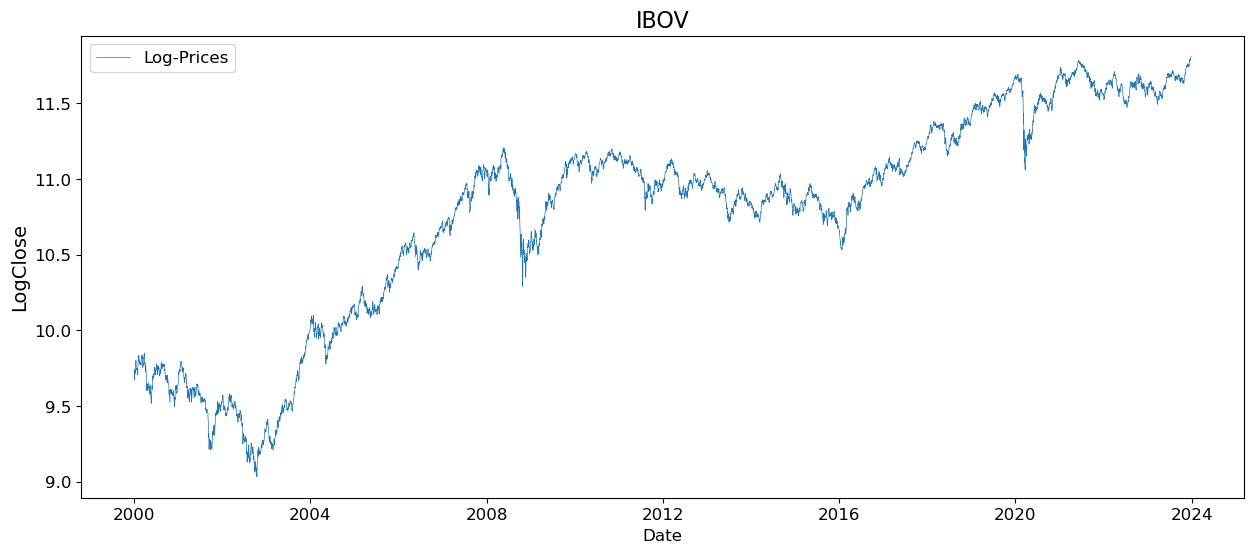

In [101]:
#===============================================================================================================================
# LOG - DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(data.index, data['Close'], label = "Log-Prices", linewidth=0.5)
plt.title(seriesId, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('LogClose', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc=2, prop={'size': 12}, bbox_to_anchor=(0,1))
plt.show()

In [102]:
#===============================================================================================================================
# LOG - TRANSF: ESTIMATES d
#===============================================================================================================================
out = d_estimates_db(data,0,1)
out

#----------------------------------------------------------------
#        adfStat          pVal  lags    nObs   95% conf      corr
#----------------------------------------------------------------
# 0.0  -0.999280  7.535267e-01  18.0  5924.0  -2.862028  1.000000
# 0.1  -1.944972  3.112096e-01   6.0  5434.0  -2.862072  0.995770
# 0.2  -2.463225  1.246803e-01  19.0  5427.0  -2.862073  0.975986
# 0.3  -3.184014  2.092888e-02  19.0  5536.0  -2.862062  0.939273
# 0.4  -3.620041  5.389245e-03  25.0  5636.0  -2.862053  0.879927
# 0.5  -4.575915  1.430372e-04  26.0  5717.0  -2.862046  0.781757
# 0.6  -5.507772  2.003778e-06  26.0  5777.0  -2.862040  0.642494
# 0.7  -6.941478  1.022448e-09  26.0  5820.0  -2.862037  0.469729
# 0.8  -8.866962  1.431788e-14  26.0  5853.0  -2.862034  0.313413
# 0.9 -13.903174  5.685239e-26  15.0  5890.0  -2.862031  0.175507
# 1.0 -16.889955  1.046976e-29  17.0  5924.0  -2.862028  0.012783

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.996
d_estimates_db: d = 0.2   correlation = 0.976
d_estimates_db: d = 0.3   correlation = 0.939
d_estimates_db: d = 0.4   correlation = 0.88
d_estimates_db: d = 0.5   correlation = 0.782
d_estimates_db: d = 0.6   correlation = 0.642
d_estimates_db: d = 0.7   correlation = 0.47
d_estimates_db: d = 0.8   correlation = 0.313
d_estimates_db: d = 0.9   correlation = 0.176
d_estimates_db: d = 1.0   correlation = 0.013


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.999280,7.535267e-01,18.0,5924.0,-2.862028,1.000000
0.1,-1.944972,3.112096e-01,6.0,5434.0,-2.862072,0.995770
0.2,-2.463225,1.246803e-01,19.0,5427.0,-2.862073,0.975986
0.3,-3.184014,2.092888e-02,19.0,5536.0,-2.862062,0.939273
0.4,-3.620041,5.389245e-03,25.0,5636.0,-2.862053,0.879927
0.5,-4.575915,1.430372e-04,26.0,5717.0,-2.862046,0.781757
0.6,-5.507772,2.003778e-06,26.0,5777.0,-2.862040,0.642494
0.7,-6.941478,1.022448e-09,26.0,5820.0,-2.862037,0.469729
0.8,-8.866962,1.431788e-14,26.0,5853.0,-2.862034,0.313413
0.9,-13.903174,5.685239e-26,15.0,5890.0,-2.862031,0.175507


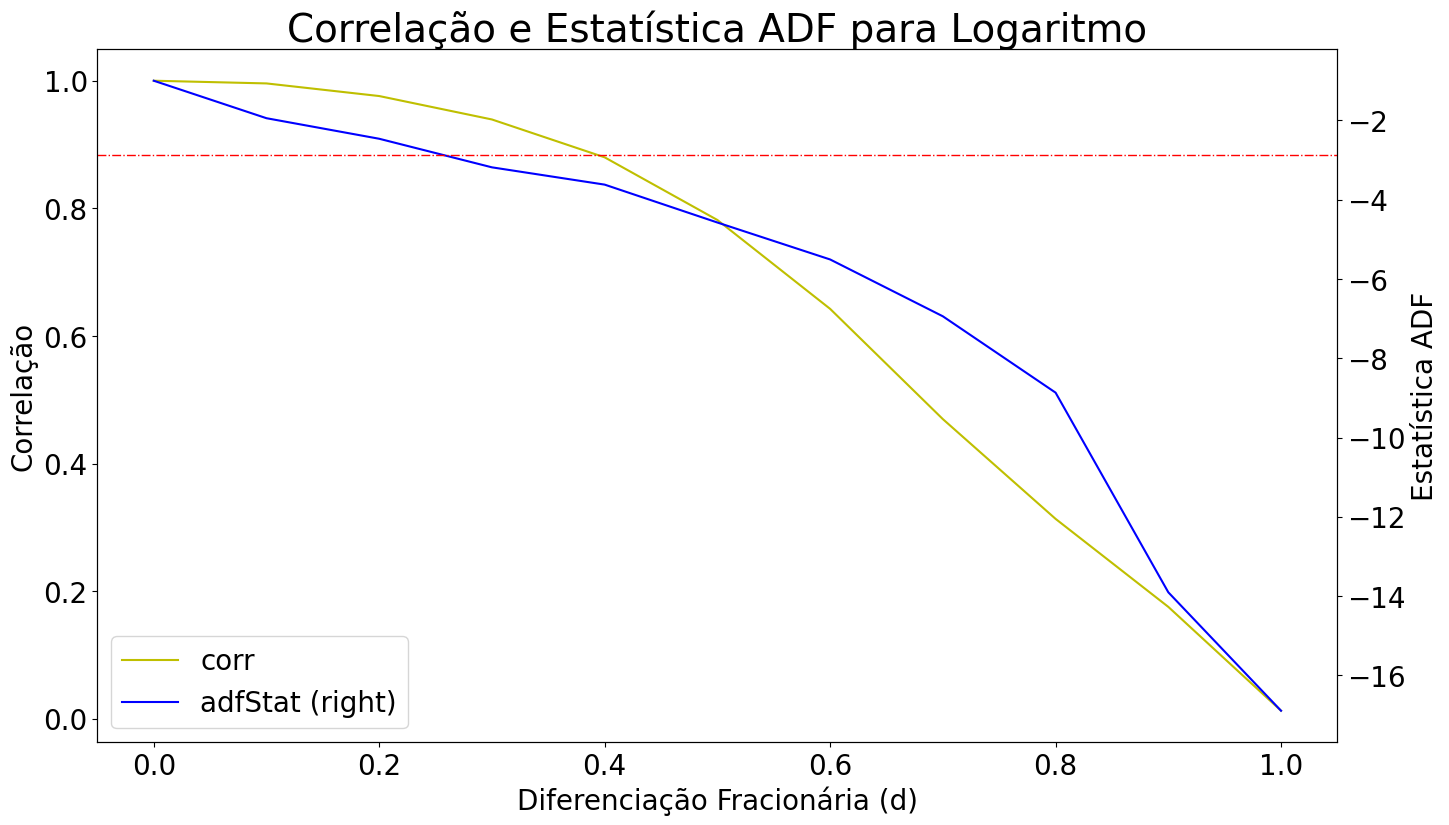

In [103]:
#===============================================================================================================================
# LOG - TRANSF: - ADF Stat, CORR vs d
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# Plot: out For d = 0.3 , p-value = 0.048, correlation = 0.85 > 0.8 (critical point).
#-------------------------------------------------------------------------------------------------------------------------------
ax1 = out['corr'].plot(figsize=(16, 9), color='y')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='b', ax=ax1)
ax1.set_title('Correlação e Estatística ADF para Logaritmo', fontsize=28)
ax1.set_xlabel('Diferenciação Fracionária (d)', fontsize=20)
ax1.set_ylabel('Correlação', fontsize=20)
ax2.set_ylabel('Estatística ADF', fontsize=20)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)
plt.axhline(out['95% conf'].mean(),linewidth=1, color='r',linestyle='-.');
# Tip!
# To get 2 legends aligned without overlapping:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)

In [104]:
#===============================================================================================================================
# LOG - TRANSF: OPTIMAL d
#===============================================================================================================================
#d = optimal_d(data, 0.035, 0, 1)
d = 0.2645
d
#-------------------------------------------------------------------------------------------------------------------------------
# d = 0.2645
#-------------------------------------------------------------------------------------------------------------------------------

0.2645

In [105]:
#===============================================================================================================================
# LOG - TRANSF: RESIDUALS
#===============================================================================================================================
fracdiff_residuals = fracDiff_FFD(data['Close'],d)
fracdiff_residuals

,Close
2001-09-20,1.407736
2001-09-21,1.402014
2001-09-24,1.419516
2001-09-25,1.391312
2001-09-26,1.379019
...,...
2023-12-21,1.945807
2023-12-22,1.946708
2023-12-26,1.949707
2023-12-27,1.951411


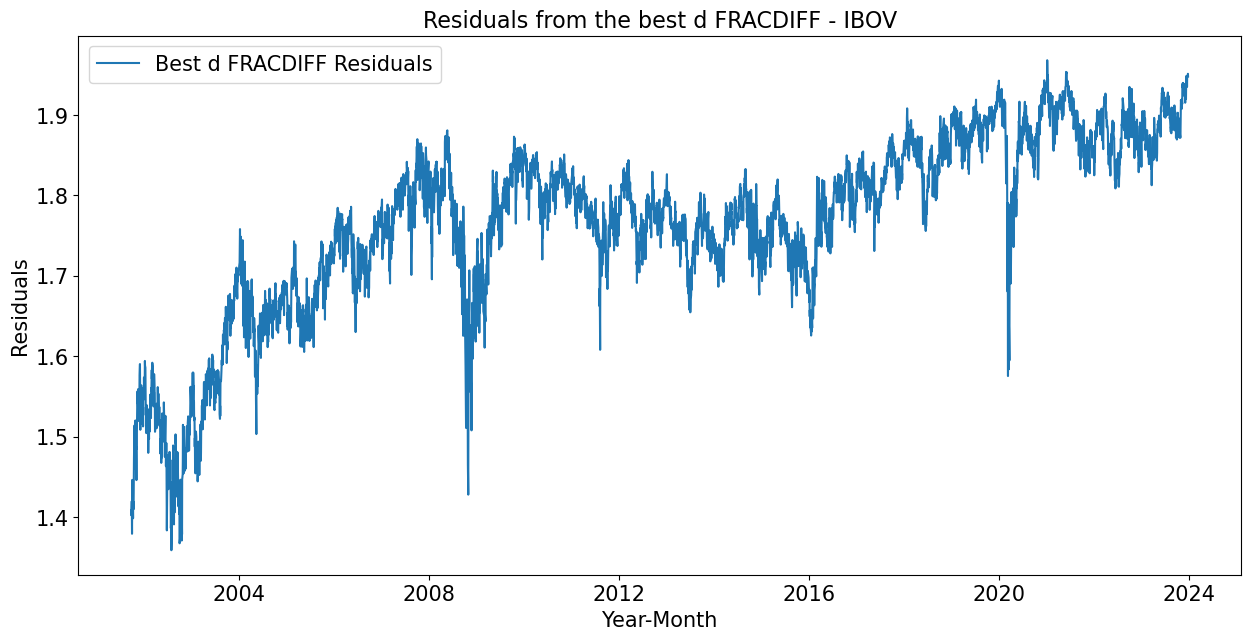

In [106]:
#===============================================================================================================================
# LOG - PLOT: FRACDIFF
#===============================================================================================================================

# Set the figure size
plt.figure(figsize=(15,7))

# Plot the residuals
plt.plot(fracdiff_residuals.index, fracdiff_residuals, label = "Best d FRACDIFF Residuals")

# Set the title of the graph
plt.title('Residuals from the best d FRACDIFF - IBOV', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [107]:
#===============================================================================================================================
# LOG - STATIONARITY: ADF Test
#===============================================================================================================================
df2=adfuller(fracdiff_residuals, regression='c', autolag='AIC')
ADF_statistics = df2[0]
p_value = df2[1]
print('ADF statistics =', round(ADF_statistics,2),chr(9), 'p_value =', round(p_value,3))

#-------------------------------------------------------------------------------------------------------------------------------
# ADF statistics = -3.08 p_value = 0.028 < 0.05
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF statistics = -3.08 	 p_value = 0.028


In [108]:
#===============================================================================================================================
# LOG - CORRELATION
#===============================================================================================================================
fracdiff_residuals.rename(columns={'Close':'Residuals'}, inplace=True)
new_df = pd.concat([data['Close'], fracdiff_residuals], axis=1).dropna()
print('Correlation = ', round(new_df.corr().loc['Close','Residuals'],4))

#-------------------------------------------------------------------------------------------------------------------------------
# Correlation =  0.9547
#-------------------------------------------------------------------------------------------------------------------------------

Correlation =  0.9547


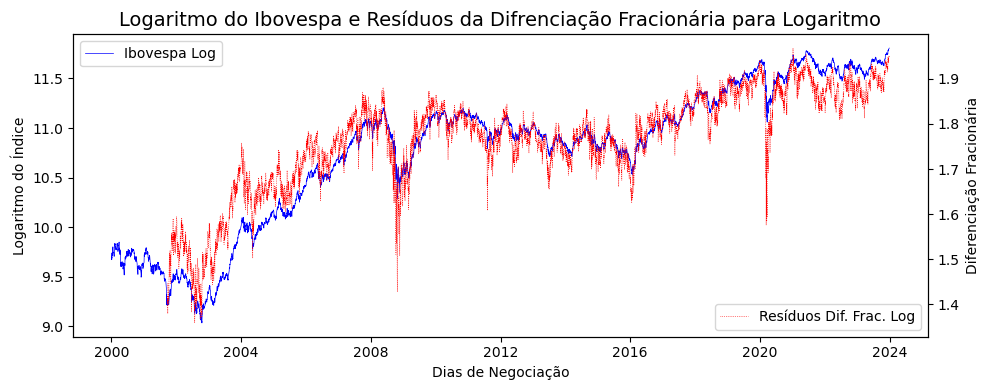

In [109]:
#===============================================================================================================================
# LOG - PLOT: SERIES vs RESIDUALS
#===============================================================================================================================
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(data['Close']     , 'b-',  label='Ibovespa Log', linewidth=0.5)
ax1.legend(loc=2)
ax1.set_xlabel('Dias de Negociação')
ax1.set_ylabel('Logaritmo do Índice')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(fracdiff_residuals  , 'r', label='Resíduos Dif. Frac. Log', linewidth=0.5, linestyle='dotted')
ax2.set_ylabel('Diferenciação Fracionária')
ax2.legend(loc=4)

plt.title('Logaritmo do Ibovespa e Resíduos da Difrenciação Fracionária para Logaritmo', fontsize=14)
#fig.autofmt_xdate()
plt.tight_layout()
#plt.show()

In [110]:
#===============================================================================================================================
# LOG - RESIDUALS: OUTPUT
#===============================================================================================================================
fracdiff_residuals.to_csv('Data/Input/IBOV-FracDiff-Daily-Ln.csv')

In [111]:
#===============================================================================================================================
# LOG - RECOVER: WEIGHTS
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-428+2)
print(len(w_FFD))
#w_FFD

5516


In [112]:
#===============================================================================================================================
# LOG - RECOVER: LOG
#===============================================================================================================================
fracdiff_recover = fracDiff_FFD_recover(fracdiff_residuals, d, THRESHOLD, w_FFD, data['Close'])


width= 5515 len(seriesF.index)= 5516


Loop: iloc1= 0  | loc1= 2001-09-20 00:00:00

seriesF[loc1]= 1.4077358745905437
series_ori[loc1]= 9.26322879347177
w[iloc1]= [-4.e-06]

Loop: iloc1= 1  | loc1= 2001-09-21 00:00:00

seriesF[loc1]= 1.4020136553874911
series_ori[loc1]= 9.251362346499103
w[iloc1]= [-4.e-06]

Loop: iloc1= 2  | loc1= 2001-09-24 00:00:00

seriesF[loc1]= 1.4195162050466523
series_ori[loc1]= 9.262252324955037
w[iloc1]= [-4.e-06]

Loop: iloc1= 3  | loc1= 2001-09-25 00:00:00

seriesF[loc1]= 1.391312343309795
series_ori[loc1]= 9.23298699050841
w[iloc1]= [-4.e-06]

Loop: iloc1= 4  | loc1= 2001-09-26 00:00:00

seriesF[loc1]= 1.379018520736663
series_ori[loc1]= 9.210927199759073
w[iloc1]= [-4.e-06]

Loop: iloc1= 5  | loc1= 2001-09-27 00:00:00

seriesF[loc1]= 1.4287926074020336
series_ori[loc1]= 9.250014828326295
w[iloc1]= [-4.e-06]

Loop: iloc1= 6  | loc1= 2001-09-28 00:00:00

seriesF[loc1]= 1.4460958361756906
series_ori[loc1]= 9.27197530678394
w[iloc1]= [-4.e-06]

Loop: iloc1= 7


Loop: iloc1= 123  | loc1= 2002-03-26 00:00:00

seriesF[loc1]= 1.5405118190178433
series_ori[loc1]= 9.515613068223749
w[iloc1]= [-4.e-06]

Loop: iloc1= 124  | loc1= 2002-03-27 00:00:00

seriesF[loc1]= 1.526767525812891
series_ori[loc1]= 9.504853062548763
w[iloc1]= [-4.e-06]

Loop: iloc1= 125  | loc1= 2002-03-28 00:00:00

seriesF[loc1]= 1.5166047728530874
series_ori[loc1]= 9.492096168693793
w[iloc1]= [-4.e-06]

Loop: iloc1= 126  | loc1= 2002-04-01 00:00:00

seriesF[loc1]= 1.537095493864566
series_ori[loc1]= 9.508026486709934
w[iloc1]= [-4.e-06]

Loop: iloc1= 127  | loc1= 2002-04-02 00:00:00

seriesF[loc1]= 1.5183033427352317
series_ori[loc1]= 9.491389746639143
w[iloc1]= [-4.e-06]

Loop: iloc1= 128  | loc1= 2002-04-03 00:00:00

seriesF[loc1]= 1.5103162081588515
series_ori[loc1]= 9.479207294415568
w[iloc1]= [-4.e-06]

Loop: iloc1= 129  | loc1= 2002-04-04 00:00:00

seriesF[loc1]= 1.536092075546616
series_ori[loc1]= 9.500044398899599
w[iloc1]= [-4.e-06]

Loop: iloc1= 130  | loc1= 2002-04-05


seriesF[loc1]= 1.4435863388581422
series_ori[loc1]= 9.18631301305551
w[iloc1]= [-4.e-06]

Loop: iloc1= 211  | loc1= 2002-08-01 00:00:00

seriesF[loc1]= 1.4346500257674402
series_ori[loc1]= 9.186010793480959
w[iloc1]= [-4.e-06]

Loop: iloc1= 212  | loc1= 2002-08-02 00:00:00

seriesF[loc1]= 1.4425925795688923
series_ori[loc1]= 9.195432804302785
w[iloc1]= [-4.e-06]

Loop: iloc1= 213  | loc1= 2002-08-05 00:00:00

seriesF[loc1]= 1.4005021058827705
series_ori[loc1]= 9.15586729057805
w[iloc1]= [-4.e-06]

Loop: iloc1= 214  | loc1= 2002-08-06 00:00:00

seriesF[loc1]= 1.4402027382857305
series_ori[loc1]= 9.185543453946188
w[iloc1]= [-4.e-06]

Loop: iloc1= 215  | loc1= 2002-08-07 00:00:00

seriesF[loc1]= 1.4480279206966236
series_ori[loc1]= 9.197214604757255
w[iloc1]= [-4.e-06]

Loop: iloc1= 216  | loc1= 2002-08-08 00:00:00

seriesF[loc1]= 1.4888977940782704
series_ori[loc1]= 9.241420346745006
w[iloc1]= [-4.e-06]

Loop: iloc1= 217  | loc1= 2002-08-09 00:00:00

seriesF[loc1]= 1.4439522083846734
s


Loop: iloc1= 367  | loc1= 2003-03-18 00:00:00

seriesF[loc1]= 1.5387168511648723
series_ori[loc1]= 9.319283562184403
w[iloc1]= [-4.e-06]

Loop: iloc1= 368  | loc1= 2003-03-19 00:00:00

seriesF[loc1]= 1.51721226949571
series_ori[loc1]= 9.306231292209047
w[iloc1]= [-4.e-06]

Loop: iloc1= 369  | loc1= 2003-03-20 00:00:00

seriesF[loc1]= 1.530741143471566
series_ori[loc1]= 9.3199998339088
w[iloc1]= [-4.e-06]

Loop: iloc1= 370  | loc1= 2003-03-21 00:00:00

seriesF[loc1]= 1.5454045630266386
series_ori[loc1]= 9.339385968444411
w[iloc1]= [-4.e-06]

Loop: iloc1= 371  | loc1= 2003-03-24 00:00:00

seriesF[loc1]= 1.5090055937355062
series_ori[loc1]= 9.31042278291357
w[iloc1]= [-4.e-06]

Loop: iloc1= 372  | loc1= 2003-03-25 00:00:00

seriesF[loc1]= 1.5293100884641913
series_ori[loc1]= 9.326545274145825
w[iloc1]= [-4.e-06]

Loop: iloc1= 373  | loc1= 2003-03-26 00:00:00

seriesF[loc1]= 1.5232351302020066
series_ori[loc1]= 9.324231399139363
w[iloc1]= [-4.e-06]

Loop: iloc1= 374  | loc1= 2003-03-27 00


seriesF[loc1]= 1.6912643515918666
series_ori[loc1]= 9.926153234240532
w[iloc1]= [-5.e-06]

Loop: iloc1= 548  | loc1= 2003-12-03 00:00:00

seriesF[loc1]= 1.691894965705976
series_ori[loc1]= 9.930110009096236
w[iloc1]= [-5.e-06]

Loop: iloc1= 549  | loc1= 2003-12-04 00:00:00

seriesF[loc1]= 1.6820154759671366
series_ori[loc1]= 9.92398454654707
w[iloc1]= [-5.e-06]

Loop: iloc1= 550  | loc1= 2003-12-05 00:00:00

seriesF[loc1]= 1.7035548845013526
series_ori[loc1]= 9.946537942338315
w[iloc1]= [-5.e-06]

Loop: iloc1= 551  | loc1= 2003-12-08 00:00:00

seriesF[loc1]= 1.6964625881202613
series_ori[loc1]= 9.946973675113654
w[iloc1]= [-5.e-06]

Loop: iloc1= 552  | loc1= 2003-12-09 00:00:00

seriesF[loc1]= 1.7102309939986755
series_ori[loc1]= 9.964570892654645
w[iloc1]= [-5.e-06]

Loop: iloc1= 553  | loc1= 2003-12-10 00:00:00

seriesF[loc1]= 1.6892453758159007
series_ori[loc1]= 9.950972102857849
w[iloc1]= [-5.e-06]

Loop: iloc1= 554  | loc1= 2003-12-11 00:00:00

seriesF[loc1]= 1.7042344052449945
s


Loop: iloc1= 726  | loc1= 2004-08-23 00:00:00

seriesF[loc1]= 1.6627698763764318
series_ori[loc1]= 10.036799608608147
w[iloc1]= [-5.e-06]

Loop: iloc1= 727  | loc1= 2004-08-24 00:00:00

seriesF[loc1]= 1.66402840985966
series_ori[loc1]= 10.037587408554714
w[iloc1]= [-5.e-06]

Loop: iloc1= 728  | loc1= 2004-08-25 00:00:00

seriesF[loc1]= 1.6710078519478562
series_ori[loc1]= 10.045785840882104
w[iloc1]= [-5.e-06]

Loop: iloc1= 729  | loc1= 2004-08-26 00:00:00

seriesF[loc1]= 1.6468088707028303
series_ori[loc1]= 10.024910179061191
w[iloc1]= [-5.e-06]

Loop: iloc1= 730  | loc1= 2004-08-27 00:00:00

seriesF[loc1]= 1.6511391279460241
series_ori[loc1]= 10.025565352475379
w[iloc1]= [-5.e-06]

Loop: iloc1= 731  | loc1= 2004-08-30 00:00:00

seriesF[loc1]= 1.6635681469418517
series_ori[loc1]= 10.03754411973234
w[iloc1]= [-5.e-06]

Loop: iloc1= 732  | loc1= 2004-08-31 00:00:00

seriesF[loc1]= 1.6574523134051193
series_ori[loc1]= 10.034655717436424
w[iloc1]= [-5.e-06]

Loop: iloc1= 733  | loc1= 200


Loop: iloc1= 873  | loc1= 2005-03-30 00:00:00

seriesF[loc1]= 1.6673125115258691
series_ori[loc1]= 10.183758983890801
w[iloc1]= [-5.e-06]

Loop: iloc1= 874  | loc1= 2005-03-31 00:00:00

seriesF[loc1]= 1.6691203593299475
series_ori[loc1]= 10.189066790580581
w[iloc1]= [-5.e-06]

Loop: iloc1= 875  | loc1= 2005-04-01 00:00:00

seriesF[loc1]= 1.6733078381463367
series_ori[loc1]= 10.195180196882195
w[iloc1]= [-5.e-06]

Loop: iloc1= 876  | loc1= 2005-04-04 00:00:00

seriesF[loc1]= 1.6573109477878303
series_ori[loc1]= 10.181374938271563
w[iloc1]= [-5.e-06]

Loop: iloc1= 877  | loc1= 2005-04-05 00:00:00

seriesF[loc1]= 1.6460766373819329
series_ori[loc1]= 10.167329186693857
w[iloc1]= [-5.e-06]

Loop: iloc1= 878  | loc1= 2005-04-06 00:00:00

seriesF[loc1]= 1.6373852481283384
series_ori[loc1]= 10.15405364532831
w[iloc1]= [-5.e-06]

Loop: iloc1= 879  | loc1= 2005-04-07 00:00:00

seriesF[loc1]= 1.6662852697308317
series_ori[loc1]= 10.177621892487638
w[iloc1]= [-5.e-06]

Loop: iloc1= 880  | loc1= 2


Loop: iloc1= 1008  | loc1= 2005-10-10 00:00:00

seriesF[loc1]= 1.7037158735117002
series_ori[loc1]= 10.31815089356118
w[iloc1]= [-5.e-06]

Loop: iloc1= 1009  | loc1= 2005-10-11 00:00:00

seriesF[loc1]= 1.7120523159960492
series_ori[loc1]= 10.329220212526025
w[iloc1]= [-5.e-06]

Loop: iloc1= 1010  | loc1= 2005-10-13 00:00:00

seriesF[loc1]= 1.683945900640079
series_ori[loc1]= 10.304945977933944
w[iloc1]= [-5.e-06]

Loop: iloc1= 1011  | loc1= 2005-10-14 00:00:00

seriesF[loc1]= 1.6850652620711428
series_ori[loc1]= 10.301263843972439
w[iloc1]= [-5.e-06]

Loop: iloc1= 1012  | loc1= 2005-10-17 00:00:00

seriesF[loc1]= 1.7030589056404564
series_ori[loc1]= 10.316974069616972
w[iloc1]= [-5.e-06]

Loop: iloc1= 1013  | loc1= 2005-10-18 00:00:00

seriesF[loc1]= 1.66022783014858
series_ori[loc1]= 10.277390095543485
w[iloc1]= [-5.e-06]

Loop: iloc1= 1014  | loc1= 2005-10-19 00:00:00

seriesF[loc1]= 1.6774756508764357
series_ori[loc1]= 10.285244155328138
w[iloc1]= [-5.e-06]

Loop: iloc1= 1015  | lo


Loop: iloc1= 1166  | loc1= 2006-06-01 00:00:00

seriesF[loc1]= 1.7338654118783032
series_ori[loc1]= 10.538695720550567
w[iloc1]= [-5.e-06]

Loop: iloc1= 1167  | loc1= 2006-06-02 00:00:00

seriesF[loc1]= 1.7322735462117045
series_ori[loc1]= 10.543818700984312
w[iloc1]= [-5.e-06]

Loop: iloc1= 1168  | loc1= 2006-06-05 00:00:00

seriesF[loc1]= 1.6968753182667866
series_ori[loc1]= 10.51161754820116
w[iloc1]= [-5.e-06]

Loop: iloc1= 1169  | loc1= 2006-06-06 00:00:00

seriesF[loc1]= 1.6990878999719365
series_ori[loc1]= 10.506649848702791
w[iloc1]= [-5.e-06]

Loop: iloc1= 1170  | loc1= 2006-06-07 00:00:00

seriesF[loc1]= 1.6667408279974252
series_ori[loc1]= 10.470617892512585
w[iloc1]= [-5.e-06]

Loop: iloc1= 1171  | loc1= 2006-06-08 00:00:00

seriesF[loc1]= 1.682983192762456
series_ori[loc1]= 10.47553376167346
w[iloc1]= [-5.e-06]

Loop: iloc1= 1172  | loc1= 2006-06-09 00:00:00

seriesF[loc1]= 1.6760459652164257
series_ori[loc1]= 10.465233356091074
w[iloc1]= [-5.e-06]

Loop: iloc1= 1173  | l


Loop: iloc1= 1249  | loc1= 2006-09-28 00:00:00

seriesF[loc1]= 1.7191540600939392
series_ori[loc1]= 10.504689111811446
w[iloc1]= [-5.e-06]

Loop: iloc1= 1250  | loc1= 2006-09-29 00:00:00

seriesF[loc1]= 1.7138709341574079
series_ori[loc1]= 10.503680276395972
w[iloc1]= [-5.e-06]

Loop: iloc1= 1251  | loc1= 2006-10-02 00:00:00

seriesF[loc1]= 1.7288333660836885
series_ori[loc1]= 10.520232785637942
w[iloc1]= [-5.e-06]

Loop: iloc1= 1252  | loc1= 2006-10-03 00:00:00

seriesF[loc1]= 1.7065511293659483
series_ori[loc1]= 10.5033551153046
w[iloc1]= [-5.e-06]

Loop: iloc1= 1253  | loc1= 2006-10-04 00:00:00

seriesF[loc1]= 1.7440526920842485
series_ori[loc1]= 10.538721946553279
w[iloc1]= [-5.e-06]

Loop: iloc1= 1254  | loc1= 2006-10-05 00:00:00

seriesF[loc1]= 1.7408797663028213
series_ori[loc1]= 10.54473230585635
w[iloc1]= [-5.e-06]

Loop: iloc1= 1255  | loc1= 2006-10-06 00:00:00

seriesF[loc1]= 1.734781387920584
series_ori[loc1]= 10.543772840680587
w[iloc1]= [-5.e-06]

Loop: iloc1= 1256  | lo


Loop: iloc1= 1340  | loc1= 2007-02-14 00:00:00

seriesF[loc1]= 1.7886659029293002
series_ori[loc1]= 10.736301018722358
w[iloc1]= [-6.e-06]

Loop: iloc1= 1341  | loc1= 2007-02-15 00:00:00

seriesF[loc1]= 1.780842048500595
series_ori[loc1]= 10.735419459020296
w[iloc1]= [-6.e-06]

Loop: iloc1= 1342  | loc1= 2007-02-16 00:00:00

seriesF[loc1]= 1.7756685978506246
series_ori[loc1]= 10.733109321517528
w[iloc1]= [-6.e-06]

Loop: iloc1= 1343  | loc1= 2007-02-21 00:00:00

seriesF[loc1]= 1.7796027615880452
series_ori[loc1]= 10.738356492904295
w[iloc1]= [-6.e-06]

Loop: iloc1= 1344  | loc1= 2007-02-22 00:00:00

seriesF[loc1]= 1.7848118927528134
series_ori[loc1]= 10.746180397525563
w[iloc1]= [-6.e-06]

Loop: iloc1= 1345  | loc1= 2007-02-23 00:00:00

seriesF[loc1]= 1.7717462966973772
series_ori[loc1]= 10.736739877440263
w[iloc1]= [-6.e-06]

Loop: iloc1= 1346  | loc1= 2007-02-26 00:00:00

seriesF[loc1]= 1.7764331613532094
series_ori[loc1]= 10.740895237403652
w[iloc1]= [-6.e-06]

Loop: iloc1= 1347  |


Loop: iloc1= 1475  | loc1= 2007-08-30 00:00:00

seriesF[loc1]= 1.785623880310637
series_ori[loc1]= 10.875361324667306
w[iloc1]= [-6.e-06]

Loop: iloc1= 1476  | loc1= 2007-08-31 00:00:00

seriesF[loc1]= 1.8165690521422517
series_ori[loc1]= 10.90847098052378
w[iloc1]= [-6.e-06]

Loop: iloc1= 1477  | loc1= 2007-09-03 00:00:00

seriesF[loc1]= 1.810208310444159
series_ori[loc1]= 10.912038545209157
w[iloc1]= [-6.e-06]

Loop: iloc1= 1478  | loc1= 2007-09-04 00:00:00

seriesF[loc1]= 1.8128239208695334
series_ori[loc1]= 10.919632126131146
w[iloc1]= [-6.e-06]

Loop: iloc1= 1479  | loc1= 2007-09-05 00:00:00

seriesF[loc1]= 1.7926129019081904
series_ori[loc1]= 10.904263356310084
w[iloc1]= [-6.e-06]

Loop: iloc1= 1480  | loc1= 2007-09-06 00:00:00

seriesF[loc1]= 1.7969166029331585
series_ori[loc1]= 10.907221234925327
w[iloc1]= [-6.e-06]

Loop: iloc1= 1481  | loc1= 2007-09-10 00:00:00

seriesF[loc1]= 1.7599343642951966
series_ori[loc1]= 10.87147032928629
w[iloc1]= [-6.e-06]

Loop: iloc1= 1482  | lo


Loop: iloc1= 1623  | loc1= 2008-04-11 00:00:00

seriesF[loc1]= 1.7970352885838103
series_ori[loc1]= 11.0442842671931
w[iloc1]= [-6.e-06]

Loop: iloc1= 1624  | loc1= 2008-04-14 00:00:00

seriesF[loc1]= 1.7938766050800385
series_ori[loc1]= 11.037361606259006
w[iloc1]= [-6.e-06]

Loop: iloc1= 1625  | loc1= 2008-04-15 00:00:00

seriesF[loc1]= 1.804317170961931
series_ori[loc1]= 11.044814283914294
w[iloc1]= [-6.e-06]

Loop: iloc1= 1626  | loc1= 2008-04-16 00:00:00

seriesF[loc1]= 1.8277251388588907
series_ori[loc1]= 11.069009611207715
w[iloc1]= [-6.e-06]

Loop: iloc1= 1627  | loc1= 2008-04-17 00:00:00

seriesF[loc1]= 1.827455942733359
series_ori[loc1]= 11.075232885889628
w[iloc1]= [-6.e-06]

Loop: iloc1= 1628  | loc1= 2008-04-18 00:00:00

seriesF[loc1]= 1.8291219206667702
series_ori[loc1]= 11.080952148324403
w[iloc1]= [-6.e-06]

Loop: iloc1= 1629  | loc1= 2008-04-22 00:00:00

seriesF[loc1]= 1.833090621759749
series_ori[loc1]= 11.08847109669314
w[iloc1]= [-6.e-06]

Loop: iloc1= 1630  | loc1


Loop: iloc1= 1750  | loc1= 2008-10-13 00:00:00

seriesF[loc1]= 1.6704480341194707
series_ori[loc1]= 10.61715107622474
w[iloc1]= [-6.e-06]

Loop: iloc1= 1751  | loc1= 2008-10-14 00:00:00

seriesF[loc1]= 1.6648500935694295
series_ori[loc1]= 10.635110697839245
w[iloc1]= [-6.e-06]

Loop: iloc1= 1752  | loc1= 2008-10-15 00:00:00

seriesF[loc1]= 1.5349036223448849
series_ori[loc1]= 10.514150004448322
w[iloc1]= [-6.e-06]

Loop: iloc1= 1753  | loc1= 2008-10-16 00:00:00

seriesF[loc1]= 1.5539189288124775
series_ori[loc1]= 10.503469551138124
w[iloc1]= [-6.e-06]

Loop: iloc1= 1754  | loc1= 2008-10-17 00:00:00

seriesF[loc1]= 1.5669765004007323
series_ori[loc1]= 10.502299053312326
w[iloc1]= [-6.e-06]

Loop: iloc1= 1755  | loc1= 2008-10-20 00:00:00

seriesF[loc1]= 1.6558152979899772
series_ori[loc1]= 10.582563191708795
w[iloc1]= [-6.e-06]

Loop: iloc1= 1756  | loc1= 2008-10-21 00:00:00

seriesF[loc1]= 1.6305961929857578
series_ori[loc1]= 10.572428870773567
w[iloc1]= [-6.e-06]

Loop: iloc1= 1757  |


Loop: iloc1= 1813  | loc1= 2009-01-15 00:00:00

seriesF[loc1]= 1.6795745472549548
series_ori[loc1]= 10.575183287245354
w[iloc1]= [-7.e-06]

Loop: iloc1= 1814  | loc1= 2009-01-16 00:00:00

seriesF[loc1]= 1.6813173147657254
series_ori[loc1]= 10.580036237084343
w[iloc1]= [-7.e-06]

Loop: iloc1= 1815  | loc1= 2009-01-19 00:00:00

seriesF[loc1]= 1.6668853639917
series_ori[loc1]= 10.56690515627338
w[iloc1]= [-7.e-06]

Loop: iloc1= 1816  | loc1= 2009-01-20 00:00:00

seriesF[loc1]= 1.6293061858974163
series_ori[loc1]= 10.525999531580295
w[iloc1]= [-7.e-06]

Loop: iloc1= 1817  | loc1= 2009-01-21 00:00:00

seriesF[loc1]= 1.6750210924988078
series_ori[loc1]= 10.559527185634627
w[iloc1]= [-7.e-06]

Loop: iloc1= 1818  | loc1= 2009-01-22 00:00:00

seriesF[loc1]= 1.654058730387415
series_ori[loc1]= 10.542556775657054
w[iloc1]= [-7.e-06]

Loop: iloc1= 1819  | loc1= 2009-01-23 00:00:00

seriesF[loc1]= 1.664534980395434
series_ori[loc1]= 10.548818282213956
w[iloc1]= [-7.e-06]

Loop: iloc1= 1820  | loc1


Loop: iloc1= 1901  | loc1= 2009-05-26 00:00:00

seriesF[loc1]= 1.801794277737839
series_ori[loc1]= 10.855932763005848
w[iloc1]= [-7.e-06]

Loop: iloc1= 1902  | loc1= 2009-05-27 00:00:00

seriesF[loc1]= 1.7942257494748866
series_ori[loc1]= 10.854983446017192
w[iloc1]= [-7.e-06]

Loop: iloc1= 1903  | loc1= 2009-05-28 00:00:00

seriesF[loc1]= 1.8153010798535134
series_ori[loc1]= 10.87881557649696
w[iloc1]= [-7.e-06]

Loop: iloc1= 1904  | loc1= 2009-05-29 00:00:00

seriesF[loc1]= 1.8099999226738244
series_ori[loc1]= 10.88177100524645
w[iloc1]= [-7.e-06]

Loop: iloc1= 1905  | loc1= 2009-06-01 00:00:00

seriesF[loc1]= 1.8292901896825446
series_ori[loc1]= 10.905704389371875
w[iloc1]= [-7.e-06]

Loop: iloc1= 1906  | loc1= 2009-06-02 00:00:00

seriesF[loc1]= 1.8110621279090005
series_ori[loc1]= 10.896730436618016
w[iloc1]= [-7.e-06]

Loop: iloc1= 1907  | loc1= 2009-06-03 00:00:00

seriesF[loc1]= 1.7728286362818961
series_ori[loc1]= 10.86066357292743
w[iloc1]= [-7.e-06]

Loop: iloc1= 1908  | lo


Loop: iloc1= 2006  | loc1= 2009-10-26 00:00:00

seriesF[loc1]= 1.835877117273808
series_ori[loc1]= 11.083457837352679
w[iloc1]= [-7.e-06]

Loop: iloc1= 2007  | loc1= 2009-10-27 00:00:00

seriesF[loc1]= 1.8059886733442179
series_ori[loc1]= 11.053442934351809
w[iloc1]= [-7.e-06]

Loop: iloc1= 2008  | loc1= 2009-10-28 00:00:00

seriesF[loc1]= 1.7649962909880381
series_ori[loc1]= 11.004801355492935
w[iloc1]= [-7.e-06]

Loop: iloc1= 2009  | loc1= 2009-10-29 00:00:00

seriesF[loc1]= 1.8377996914557642
series_ori[loc1]= 11.06226286630522
w[iloc1]= [-7.e-06]

Loop: iloc1= 2010  | loc1= 2009-10-30 00:00:00

seriesF[loc1]= 1.793784553622027
series_ori[loc1]= 11.027532017648205
w[iloc1]= [-7.e-06]

Loop: iloc1= 2011  | loc1= 2009-11-03 00:00:00

seriesF[loc1]= 1.8184202817854032
series_ori[loc1]= 11.045210893830811
w[iloc1]= [-7.e-06]

Loop: iloc1= 2012  | loc1= 2009-11-04 00:00:00

seriesF[loc1]= 1.8361447974776146
series_ori[loc1]= 11.065271334635064
w[iloc1]= [-7.e-06]

Loop: iloc1= 2013  | l


Loop: iloc1= 2070  | loc1= 2010-02-02 00:00:00

seriesF[loc1]= 1.8297466815396808
series_ori[loc1]= 11.114880906356596
w[iloc1]= [-7.e-06]

Loop: iloc1= 2071  | loc1= 2010-02-03 00:00:00

seriesF[loc1]= 1.8256021877896984
series_ori[loc1]= 11.114066885613179
w[iloc1]= [-7.e-06]

Loop: iloc1= 2072  | loc1= 2010-02-04 00:00:00

seriesF[loc1]= 1.7760794097776995
series_ori[loc1]= 11.065606736648961
w[iloc1]= [-7.e-06]

Loop: iloc1= 2073  | loc1= 2010-02-05 00:00:00

seriesF[loc1]= 1.7697767316597632
series_ori[loc1]= 11.047116226954095
w[iloc1]= [-7.e-06]

Loop: iloc1= 2074  | loc1= 2010-02-08 00:00:00

seriesF[loc1]= 1.785165539605849
series_ori[loc1]= 11.053317057697939
w[iloc1]= [-7.e-06]

Loop: iloc1= 2075  | loc1= 2010-02-09 00:00:00

seriesF[loc1]= 1.8122278203265916
series_ori[loc1]= 11.077797275683661
w[iloc1]= [-7.e-06]

Loop: iloc1= 2076  | loc1= 2010-02-10 00:00:00

seriesF[loc1]= 1.812952561837513
series_ori[loc1]= 11.082933313064423
w[iloc1]= [-7.e-06]

Loop: iloc1= 2077  | 


Loop: iloc1= 2185  | loc1= 2010-07-21 00:00:00

seriesF[loc1]= 1.8093733869502202
series_ori[loc1]= 11.074061368535437
w[iloc1]= [-7.e-06]

Loop: iloc1= 2186  | loc1= 2010-07-22 00:00:00

seriesF[loc1]= 1.8266983045894944
series_ori[loc1]= 11.093586052284072
w[iloc1]= [-7.e-06]

Loop: iloc1= 2187  | loc1= 2010-07-23 00:00:00

seriesF[loc1]= 1.8289395673668425
series_ori[loc1]= 11.102291873231987
w[iloc1]= [-7.e-06]

Loop: iloc1= 2188  | loc1= 2010-07-26 00:00:00

seriesF[loc1]= 1.8256350760753648
series_ori[loc1]= 11.104103629350707
w[iloc1]= [-7.e-06]

Loop: iloc1= 2189  | loc1= 2010-07-27 00:00:00

seriesF[loc1]= 1.8259973809642798
series_ori[loc1]= 11.107576950064812
w[iloc1]= [-7.e-06]

Loop: iloc1= 2190  | loc1= 2010-07-28 00:00:00

seriesF[loc1]= 1.8251185260564582
series_ori[loc1]= 11.109581854892882
w[iloc1]= [-7.e-06]

Loop: iloc1= 2191  | loc1= 2010-07-29 00:00:00

seriesF[loc1]= 1.8249794530617152
series_ori[loc1]= 11.111758556353868
w[iloc1]= [-7.e-06]

Loop: iloc1= 2192  


Loop: iloc1= 2293  | loc1= 2010-12-27 00:00:00

seriesF[loc1]= 1.797078149078124
series_ori[loc1]= 11.124364080512
w[iloc1]= [-8.e-06]

Loop: iloc1= 2294  | loc1= 2010-12-28 00:00:00

seriesF[loc1]= 1.8028739126422808
series_ori[loc1]= 11.12786486181707
w[iloc1]= [-8.e-06]

Loop: iloc1= 2295  | loc1= 2010-12-29 00:00:00

seriesF[loc1]= 1.8160082964879383
series_ori[loc1]= 11.141171980502557
w[iloc1]= [-8.e-06]

Loop: iloc1= 2296  | loc1= 2010-12-30 00:00:00

seriesF[loc1]= 1.81765519338418
series_ori[loc1]= 11.146269591138754
w[iloc1]= [-8.e-06]

Loop: iloc1= 2297  | loc1= 2011-01-03 00:00:00

seriesF[loc1]= 1.8245270072692215
series_ori[loc1]= 11.155712090389445
w[iloc1]= [-8.e-06]

Loop: iloc1= 2298  | loc1= 2011-01-04 00:00:00

seriesF[loc1]= 1.8259138357180902
series_ori[loc1]= 11.16078010410638
w[iloc1]= [-8.e-06]

Loop: iloc1= 2299  | loc1= 2011-01-05 00:00:00

seriesF[loc1]= 1.8338445626589377
series_ori[loc1]= 11.171716447494894
w[iloc1]= [-8.e-06]

Loop: iloc1= 2300  | loc1= 


Loop: iloc1= 2432  | loc1= 2011-07-19 00:00:00

seriesF[loc1]= 1.747793339219046
series_ori[loc1]= 10.986683788805179
w[iloc1]= [-8.e-06]

Loop: iloc1= 2433  | loc1= 2011-07-20 00:00:00

seriesF[loc1]= 1.7496979870609763
series_ori[loc1]= 10.987319650332651
w[iloc1]= [-8.e-06]

Loop: iloc1= 2434  | loc1= 2011-07-21 00:00:00

seriesF[loc1]= 1.7699416837855146
series_ori[loc1]= 11.006472766016426
w[iloc1]= [-8.e-06]

Loop: iloc1= 2435  | loc1= 2011-07-22 00:00:00

seriesF[loc1]= 1.7660025454452004
series_ori[loc1]= 11.006597544687931
w[iloc1]= [-8.e-06]

Loop: iloc1= 2436  | loc1= 2011-07-25 00:00:00

seriesF[loc1]= 1.759989125661043
series_ori[loc1]= 11.001608720624267
w[iloc1]= [-8.e-06]

Loop: iloc1= 2437  | loc1= 2011-07-26 00:00:00

seriesF[loc1]= 1.7504202075375819
series_ori[loc1]= 10.991037208639483
w[iloc1]= [-8.e-06]

Loop: iloc1= 2438  | loc1= 2011-07-27 00:00:00

seriesF[loc1]= 1.735765654489001
series_ori[loc1]= 10.973159411064582
w[iloc1]= [-8.e-06]

Loop: iloc1= 2439  | l


Loop: iloc1= 2583  | loc1= 2012-02-27 00:00:00

seriesF[loc1]= 1.8065324813228045
series_ori[loc1]= 11.085850895223384
w[iloc1]= [-9.e-06]

Loop: iloc1= 2584  | loc1= 2012-02-28 00:00:00

seriesF[loc1]= 1.819584340273114
series_ori[loc1]= 11.096785280444264
w[iloc1]= [-9.e-06]

Loop: iloc1= 2585  | loc1= 2012-02-29 00:00:00

seriesF[loc1]= 1.814869472668808
series_ori[loc1]= 11.094553368902854
w[iloc1]= [-9.e-06]

Loop: iloc1= 2586  | loc1= 2012-03-01 00:00:00

seriesF[loc1]= 1.829472289556711
series_ori[loc1]= 11.109605055351205
w[iloc1]= [-9.e-06]

Loop: iloc1= 2587  | loc1= 2012-03-02 00:00:00

seriesF[loc1]= 1.839410398877107
series_ori[loc1]= 11.124046050665847
w[iloc1]= [-9.e-06]

Loop: iloc1= 2588  | loc1= 2012-03-05 00:00:00

seriesF[loc1]= 1.8215061063307778
series_ori[loc1]= 11.111910888537487
w[iloc1]= [-9.e-06]

Loop: iloc1= 2589  | loc1= 2012-03-06 00:00:00

seriesF[loc1]= 1.793998666334781
series_ori[loc1]= 11.083897162488759
w[iloc1]= [-9.e-06]

Loop: iloc1= 2590  | loc


Loop: iloc1= 2702  | loc1= 2012-08-16 00:00:00

seriesF[loc1]= 1.7991516733156971
series_ori[loc1]= 10.992820083799764
w[iloc1]= [-9.e-06]

Loop: iloc1= 2703  | loc1= 2012-08-17 00:00:00

seriesF[loc1]= 1.7873089051365145
series_ori[loc1]= 10.9866878509389
w[iloc1]= [-9.e-06]

Loop: iloc1= 2704  | loc1= 2012-08-20 00:00:00

seriesF[loc1]= 1.7900750851691183
series_ori[loc1]= 10.990079384117553
w[iloc1]= [-9.e-06]

Loop: iloc1= 2705  | loc1= 2012-08-21 00:00:00

seriesF[loc1]= 1.782181785042714
series_ori[loc1]= 10.983897343018368
w[iloc1]= [-9.e-06]

Loop: iloc1= 2706  | loc1= 2012-08-22 00:00:00

seriesF[loc1]= 1.7906208421408212
series_ori[loc1]= 10.991725547158042
w[iloc1]= [-9.e-06]

Loop: iloc1= 2707  | loc1= 2012-08-23 00:00:00

seriesF[loc1]= 1.7736229276286526
series_ori[loc1]= 10.976979449629482
w[iloc1]= [-9.e-06]

Loop: iloc1= 2708  | loc1= 2012-08-24 00:00:00

seriesF[loc1]= 1.7749996083123554
series_ori[loc1]= 10.975512167452536
w[iloc1]= [-9.e-06]

Loop: iloc1= 2709  | l


Loop: iloc1= 2832  | loc1= 2013-03-04 00:00:00

seriesF[loc1]= 1.7524852221624796
series_ori[loc1]= 10.941981226761143
w[iloc1]= [-1.e-05]

Loop: iloc1= 2833  | loc1= 2013-03-05 00:00:00

seriesF[loc1]= 1.7454117525097907
series_ori[loc1]= 10.932226761018672
w[iloc1]= [-1.e-05]

Loop: iloc1= 2834  | loc1= 2013-03-06 00:00:00

seriesF[loc1]= 1.7841789045751102
series_ori[loc1]= 10.96716568761314
w[iloc1]= [-1.e-05]

Loop: iloc1= 2835  | loc1= 2013-03-07 00:00:00

seriesF[loc1]= 1.7922587023039696
series_ori[loc1]= 10.982692905611769
w[iloc1]= [-1.e-05]

Loop: iloc1= 2836  | loc1= 2013-03-08 00:00:00

seriesF[loc1]= 1.7788961390152211
series_ori[loc1]= 10.975631799304907
w[iloc1]= [-1.e-05]

Loop: iloc1= 2837  | loc1= 2013-03-11 00:00:00

seriesF[loc1]= 1.7801200868352178
series_ori[loc1]= 10.977547381292021
w[iloc1]= [-1.e-05]

Loop: iloc1= 2838  | loc1= 2013-03-12 00:00:00

seriesF[loc1]= 1.7730687124838664
series_ori[loc1]= 10.971788560922091
w[iloc1]= [-1.e-05]

Loop: iloc1= 2839  |


Loop: iloc1= 2891  | loc1= 2013-05-28 00:00:00

seriesF[loc1]= 1.7638249268300532
series_ori[loc1]= 10.933754260179606
w[iloc1]= [-1.e-05]

Loop: iloc1= 2892  | loc1= 2013-05-29 00:00:00

seriesF[loc1]= 1.739757176288796
series_ori[loc1]= 10.908424307970263
w[iloc1]= [-1.e-05]

Loop: iloc1= 2893  | loc1= 2013-05-31 00:00:00

seriesF[loc1]= 1.7258625543886161
series_ori[loc1]= 10.887550571286823
w[iloc1]= [-1.e-05]

Loop: iloc1= 2894  | loc1= 2013-06-03 00:00:00

seriesF[loc1]= 1.7420842362853142
series_ori[loc1]= 10.895708423979574
w[iloc1]= [-1.e-05]

Loop: iloc1= 2895  | loc1= 2013-06-04 00:00:00

seriesF[loc1]= 1.7447606618089941
series_ori[loc1]= 10.897070752100044
w[iloc1]= [-1.e-05]

Loop: iloc1= 2896  | loc1= 2013-06-05 00:00:00

seriesF[loc1]= 1.7229185953137942
series_ori[loc1]= 10.874240522388027
w[iloc1]= [-1.e-05]

Loop: iloc1= 2897  | loc1= 2013-06-06 00:00:00

seriesF[loc1]= 1.7315082781452436
series_ori[loc1]= 10.87587180923491
w[iloc1]= [-1.e-05]

Loop: iloc1= 2898  | 


Loop: iloc1= 2995  | loc1= 2013-10-23 00:00:00

seriesF[loc1]= 1.7740004245427077
series_ori[loc1]= 10.923057174989179
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2996  | loc1= 2013-10-24 00:00:00

seriesF[loc1]= 1.7664999991948567
series_ori[loc1]= 10.9128523295644
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2997  | loc1= 2013-10-25 00:00:00

seriesF[loc1]= 1.7562003337252534
series_ori[loc1]= 10.899589888458356
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2998  | loc1= 2013-10-28 00:00:00

seriesF[loc1]= 1.7773743341652577
series_ori[loc1]= 10.916421575227126
w[iloc1]= [-1.1e-05]

Loop: iloc1= 2999  | loc1= 2013-10-29 00:00:00

seriesF[loc1]= 1.7647593440302232
series_ori[loc1]= 10.906667653957308
w[iloc1]= [-1.1e-05]

Loop: iloc1= 3000  | loc1= 2013-10-30 00:00:00

seriesF[loc1]= 1.7598032685601344
series_ori[loc1]= 10.899934585631827
w[iloc1]= [-1.1e-05]

Loop: iloc1= 3001  | loc1= 2013-10-31 00:00:00

seriesF[loc1]= 1.7636209517988903
series_ori[loc1]= 10.901472550586877
w[iloc1]= [-1.1e-05]

Loop: iloc1= 3


Loop: iloc1= 3173  | loc1= 2014-07-18 00:00:00

seriesF[loc1]= 1.810646411066041
series_ori[loc1]= 10.951032837000605
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3174  | loc1= 2014-07-21 00:00:00

seriesF[loc1]= 1.814278173622819
series_ori[loc1]= 10.961866562245854
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3175  | loc1= 2014-07-22 00:00:00

seriesF[loc1]= 1.8144095613183255
series_ori[loc1]= 10.967910661960817
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3176  | loc1= 2014-07-23 00:00:00

seriesF[loc1]= 1.8000219498247878
series_ori[loc1]= 10.958147257053426
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3177  | loc1= 2014-07-24 00:00:00

seriesF[loc1]= 1.8095977636862628
series_ori[loc1]= 10.967811318113052
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3178  | loc1= 2014-07-25 00:00:00

seriesF[loc1]= 1.803351415429082
series_ori[loc1]= 10.965108694053797
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3179  | loc1= 2014-07-28 00:00:00

seriesF[loc1]= 1.799972752132582
series_ori[loc1]= 10.962938272968527
w[iloc1]= [-1.2e-05]

Loop: iloc1= 318


Loop: iloc1= 3288  | loc1= 2015-01-02 00:00:00

seriesF[loc1]= 1.7054246703601192
series_ori[loc1]= 10.789571003952183
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3289  | loc1= 2015-01-05 00:00:00

seriesF[loc1]= 1.6934526453480725
series_ori[loc1]= 10.768839032605419
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3290  | loc1= 2015-01-06 00:00:00

seriesF[loc1]= 1.7124578317375572
series_ori[loc1]= 10.778975456373017
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3291  | loc1= 2015-01-07 00:00:00

seriesF[loc1]= 1.7438320778168284
series_ori[loc1]= 10.808978374767236
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3292  | loc1= 2015-01-08 00:00:00

seriesF[loc1]= 1.747192521782364
series_ori[loc1]= 10.818643640945778
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3293  | loc1= 2015-01-09 00:00:00

seriesF[loc1]= 1.7207427960336181
series_ori[loc1]= 10.796310046966658
w[iloc1]= [-1.2e-05]

Loop: iloc1= 3294  | loc1= 2015-01-12 00:00:00

seriesF[loc1]= 1.7107129019507852
series_ori[loc1]= 10.781863310408477
w[iloc1]= [-1.2e-05]

Loop: iloc1= 


Loop: iloc1= 3383  | loc1= 2015-05-22 00:00:00

seriesF[loc1]= 1.757871782337201
series_ori[loc1]= 10.903701882446704
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3384  | loc1= 2015-05-25 00:00:00

seriesF[loc1]= 1.766354971160299
series_ori[loc1]= 10.907958561303493
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3385  | loc1= 2015-05-26 00:00:00

seriesF[loc1]= 1.7488981558407888
series_ori[loc1]= 10.889859789786943
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3386  | loc1= 2015-05-27 00:00:00

seriesF[loc1]= 1.7655913139829473
series_ori[loc1]= 10.901104783056052
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3387  | loc1= 2015-05-28 00:00:00

seriesF[loc1]= 1.7600696386733072
series_ori[loc1]= 10.89629978451796
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3388  | loc1= 2015-05-29 00:00:00

seriesF[loc1]= 1.7388557974887404
series_ori[loc1]= 10.87351751505541
w[iloc1]= [-1.3e-05]

Loop: iloc1= 3389  | loc1= 2015-06-01 00:00:00

seriesF[loc1]= 1.7508170505854999
series_ori[loc1]= 10.878637772824364
w[iloc1]= [-1.3e-05]

Loop: iloc1= 339


Loop: iloc1= 3502  | loc1= 2015-11-12 00:00:00

seriesF[loc1]= 1.728006522222573
series_ori[loc1]= 10.75542257322862
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3503  | loc1= 2015-11-13 00:00:00

seriesF[loc1]= 1.7203033913705612
series_ori[loc1]= 10.747573761086349
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3504  | loc1= 2015-11-16 00:00:00

seriesF[loc1]= 1.7294823306430653
series_ori[loc1]= 10.754639476469968
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3505  | loc1= 2015-11-17 00:00:00

seriesF[loc1]= 1.7369697491523515
series_ori[loc1]= 10.763161370991337
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3506  | loc1= 2015-11-18 00:00:00

seriesF[loc1]= 1.7385250406399506
series_ori[loc1]= 10.767127648198334
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3507  | loc1= 2015-11-19 00:00:00

seriesF[loc1]= 1.751366464733752
series_ori[loc1]= 10.781845445590722
w[iloc1]= [-1.4e-05]

Loop: iloc1= 3508  | loc1= 2015-11-23 00:00:00

seriesF[loc1]= 1.7469013314019595
series_ori[loc1]= 10.782082024687185
w[iloc1]= [-1.4e-05]

Loop: iloc1= 35


Loop: iloc1= 3622  | loc1= 2016-05-12 00:00:00

seriesF[loc1]= 1.7909287274475885
series_ori[loc1]= 10.882589877766065
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3623  | loc1= 2016-05-13 00:00:00

seriesF[loc1]= 1.7601772900531492
series_ori[loc1]= 10.855228436385316
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3624  | loc1= 2016-05-16 00:00:00

seriesF[loc1]= 1.7657609340795006
series_ori[loc1]= 10.855201797315178
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3625  | loc1= 2016-05-17 00:00:00

seriesF[loc1]= 1.7485443810967145
series_ori[loc1]= 10.836427710293867
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3626  | loc1= 2016-05-18 00:00:00

seriesF[loc1]= 1.7487126298540874
series_ori[loc1]= 10.830949651673206
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3627  | loc1= 2016-05-19 00:00:00

seriesF[loc1]= 1.7438062805773558
series_ori[loc1]= 10.822425377765212
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3628  | loc1= 2016-05-20 00:00:00

seriesF[loc1]= 1.739616378099297
series_ori[loc1]= 10.81421765271443
w[iloc1]= [-1.5e-05]

Loop: iloc1= 3


Loop: iloc1= 3763  | loc1= 2016-12-02 00:00:00

seriesF[loc1]= 1.792750606880861
series_ori[loc1]= 11.007354677005559
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3764  | loc1= 2016-12-05 00:00:00

seriesF[loc1]= 1.7844526804154155
series_ori[loc1]= 10.999291234090531
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3765  | loc1= 2016-12-06 00:00:00

seriesF[loc1]= 1.8078849951936684
series_ori[loc1]= 11.020074655276268
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3766  | loc1= 2016-12-07 00:00:00

seriesF[loc1]= 1.8089247199217464
series_ori[loc1]= 11.025399614325211
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3767  | loc1= 2016-12-08 00:00:00

seriesF[loc1]= 1.7941831993825286
series_ori[loc1]= 11.013312741018304
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3768  | loc1= 2016-12-09 00:00:00

seriesF[loc1]= 1.793336380421822
series_ori[loc1]= 11.01040872661273
w[iloc1]= [-1.7e-05]

Loop: iloc1= 3769  | loc1= 2016-12-12 00:00:00

seriesF[loc1]= 1.7724968790599323
series_ori[loc1]= 10.98831543801361
w[iloc1]= [-1.7e-05]

Loop: iloc1= 377


Loop: iloc1= 3894  | loc1= 2017-06-14 00:00:00

seriesF[loc1]= 1.783606382509829
series_ori[loc1]= 11.033645664774461
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3895  | loc1= 2017-06-16 00:00:00

seriesF[loc1]= 1.7792011244682069
series_ori[loc1]= 11.028845791407784
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3896  | loc1= 2017-06-19 00:00:00

seriesF[loc1]= 1.7872094870531292
series_ori[loc1]= 11.035115928750017
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3897  | loc1= 2017-06-20 00:00:00

seriesF[loc1]= 1.7661009341664542
series_ori[loc1]= 11.01478816949404
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3898  | loc1= 2017-06-21 00:00:00

seriesF[loc1]= 1.7714173666619022
series_ori[loc1]= 11.014715593561027
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3899  | loc1= 2017-06-22 00:00:00

seriesF[loc1]= 1.7819140084405096
series_ori[loc1]= 11.02308167492394
w[iloc1]= [-1.9e-05]

Loop: iloc1= 3900  | loc1= 2017-06-23 00:00:00

seriesF[loc1]= 1.7779870341438828
series_ori[loc1]= 11.020056484674452
w[iloc1]= [-1.9e-05]

Loop: iloc1= 39


Loop: iloc1= 4032  | loc1= 2018-01-05 00:00:00

seriesF[loc1]= 1.868219928308252
series_ori[loc1]= 11.278107406013952
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4033  | loc1= 2018-01-08 00:00:00

seriesF[loc1]= 1.8682066242762856
series_ori[loc1]= 11.281983333625709
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4034  | loc1= 2018-01-09 00:00:00

seriesF[loc1]= 1.858353715569676
series_ori[loc1]= 11.275474296102017
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4035  | loc1= 2018-01-10 00:00:00

seriesF[loc1]= 1.8495231394282414
series_ori[loc1]= 11.267032215509396
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4036  | loc1= 2018-01-11 00:00:00

seriesF[loc1]= 1.865554179693576
series_ori[loc1]= 11.281818287996519
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4037  | loc1= 2018-01-12 00:00:00

seriesF[loc1]= 1.8612897873281273
series_ori[loc1]= 11.281612635785939
w[iloc1]= [-2.1e-05]

Loop: iloc1= 4038  | loc1= 2018-01-15 00:00:00

seriesF[loc1]= 1.8645624312566058
series_ori[loc1]= 11.286681738073863
w[iloc1]= [-2.1e-05]

Loop: iloc1= 40


Loop: iloc1= 4178  | loc1= 2018-08-08 00:00:00

seriesF[loc1]= 1.8267067258550016
series_ori[loc1]= 11.279121543284443
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4179  | loc1= 2018-08-09 00:00:00

seriesF[loc1]= 1.8256423597936586
series_ori[loc1]= 11.274261975042865
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4180  | loc1= 2018-08-10 00:00:00

seriesF[loc1]= 1.7990054726741014
series_ori[loc1]= 11.245233714617155
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4181  | loc1= 2018-08-13 00:00:00

seriesF[loc1]= 1.8203702964240618
series_ori[loc1]= 11.257987536878838
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4182  | loc1= 2018-08-14 00:00:00

seriesF[loc1]= 1.8344624571502663
series_ori[loc1]= 11.272153950063737
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4183  | loc1= 2018-08-15 00:00:00

seriesF[loc1]= 1.8117834289469674
series_ori[loc1]= 11.252566688167338
w[iloc1]= [-2.4e-05]

Loop: iloc1= 4184  | loc1= 2018-08-16 00:00:00

seriesF[loc1]= 1.8127674277702868
series_ori[loc1]= 11.249203639433558
w[iloc1]= [-2.4e-05]

Loop: iloc1=


Loop: iloc1= 4337  | loc1= 2019-04-04 00:00:00

seriesF[loc1]= 1.8829864136059942
series_ori[loc1]= 11.475359310279872
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4338  | loc1= 2019-04-05 00:00:00

seriesF[loc1]= 1.886956439012808
series_ori[loc1]= 11.483580790801632
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4339  | loc1= 2019-04-08 00:00:00

seriesF[loc1]= 1.8860158895069645
series_ori[loc1]= 11.48626614217257
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4340  | loc1= 2019-04-09 00:00:00

seriesF[loc1]= 1.8725446205808263
series_ori[loc1]= 11.47513833973856
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4341  | loc1= 2019-04-10 00:00:00

seriesF[loc1]= 1.8706622445358305
series_ori[loc1]= 11.471618457016637
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4342  | loc1= 2019-04-11 00:00:00

seriesF[loc1]= 1.8591850603529068
series_ori[loc1]= 11.45904672593606
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4343  | loc1= 2019-04-12 00:00:00

seriesF[loc1]= 1.842728914263562
series_ori[loc1]= 11.43900978202006
w[iloc1]= [-2.8e-05]

Loop: iloc1= 4344 


Loop: iloc1= 4474  | loc1= 2019-10-18 00:00:00

seriesF[loc1]= 1.8888434234340927
series_ori[loc1]= 11.5591302900287
w[iloc1]= [-3.2e-05]

Loop: iloc1= 4475  | loc1= 2019-10-21 00:00:00

seriesF[loc1]= 1.9010372890845533
series_ori[loc1]= 11.571404539686904
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4476  | loc1= 2019-10-22 00:00:00

seriesF[loc1]= 1.91011514731112
series_ori[loc1]= 11.584139561043639
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4477  | loc1= 2019-10-23 00:00:00

seriesF[loc1]= 1.9066474873432968
series_ori[loc1]= 11.585651532733754
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4478  | loc1= 2019-10-24 00:00:00

seriesF[loc1]= 1.898735004568353
series_ori[loc1]= 11.580454665813724
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4479  | loc1= 2019-10-25 00:00:00

seriesF[loc1]= 1.9019423575990189
series_ori[loc1]= 11.583978067088228
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4480  | loc1= 2019-10-28 00:00:00

seriesF[loc1]= 1.9078996806743076
series_ori[loc1]= 11.591617044897008
w[iloc1]= [-3.3e-05]

Loop: iloc1= 4481


Loop: iloc1= 4620  | loc1= 2020-05-26 00:00:00

seriesF[loc1]= 1.8424876262837486
series_ori[loc1]= 11.35590796306599
w[iloc1]= [-3.9e-05]

Loop: iloc1= 4621  | loc1= 2020-05-27 00:00:00

seriesF[loc1]= 1.867053345134548
series_ori[loc1]= 11.384481111394264
w[iloc1]= [-3.9e-05]

Loop: iloc1= 4622  | loc1= 2020-05-28 00:00:00

seriesF[loc1]= 1.8455401770577358
series_ori[loc1]= 11.373078053942729
w[iloc1]= [-3.9e-05]

Loop: iloc1= 4623  | loc1= 2020-05-29 00:00:00

seriesF[loc1]= 1.8491791891777192
series_ori[loc1]= 11.378280195071829
w[iloc1]= [-3.9e-05]

Loop: iloc1= 4624  | loc1= 2020-06-01 00:00:00

seriesF[loc1]= 1.8597834178578543
series_ori[loc1]= 11.392113973166294
w[iloc1]= [-4.e-05]

Loop: iloc1= 4625  | loc1= 2020-06-02 00:00:00

seriesF[loc1]= 1.881106807881928
series_ori[loc1]= 11.419124325990849
w[iloc1]= [-4.e-05]

Loop: iloc1= 4626  | loc1= 2020-06-03 00:00:00

seriesF[loc1]= 1.8923376931122982
series_ori[loc1]= 11.440377782623338
w[iloc1]= [-4.e-05]

Loop: iloc1= 4627 


Loop: iloc1= 4766  | loc1= 2020-12-22 00:00:00

seriesF[loc1]= 1.9239811122578843
series_ori[loc1]= 11.666814796363246
w[iloc1]= [-4.9e-05]

Loop: iloc1= 4767  | loc1= 2020-12-23 00:00:00

seriesF[loc1]= 1.9325037328416235
series_ori[loc1]= 11.676801697914785
w[iloc1]= [-4.9e-05]

Loop: iloc1= 4768  | loc1= 2020-12-28 00:00:00

seriesF[loc1]= 1.9400909836333824
series_ori[loc1]= 11.687917727990346
w[iloc1]= [-4.9e-05]

Loop: iloc1= 4769  | loc1= 2020-12-29 00:00:00

seriesF[loc1]= 1.9377753912646312
series_ori[loc1]= 11.690311110170297
w[iloc1]= [-5.e-05]

Loop: iloc1= 4770  | loc1= 2020-12-30 00:00:00

seriesF[loc1]= 1.9314634116281288
series_ori[loc1]= 11.687023635550029
w[iloc1]= [-5.e-05]

Loop: iloc1= 4771  | loc1= 2021-01-04 00:00:00

seriesF[loc1]= 1.9290160512341008
series_ori[loc1]= 11.685657101788545
w[iloc1]= [-5.e-05]

Loop: iloc1= 4772  | loc1= 2021-01-05 00:00:00

seriesF[loc1]= 1.932556885447228
series_ori[loc1]= 11.690035213857316
w[iloc1]= [-5.e-05]

Loop: iloc1= 4773


Loop: iloc1= 4945  | loc1= 2021-09-15 00:00:00

seriesF[loc1]= 1.8738787666257068
series_ori[loc1]= 11.653231085612527
w[iloc1]= [-7.e-05]

Loop: iloc1= 4946  | loc1= 2021-09-16 00:00:00

seriesF[loc1]= 1.8654602012947397
series_ori[loc1]= 11.642147535790723
w[iloc1]= [-7.e-05]

Loop: iloc1= 4947  | loc1= 2021-09-17 00:00:00

seriesF[loc1]= 1.8486148110587584
series_ori[loc1]= 11.621235955171375
w[iloc1]= [-7.e-05]

Loop: iloc1= 4948  | loc1= 2021-09-20 00:00:00

seriesF[loc1]= 1.8324235165922795
series_ori[loc1]= 11.597668554673588
w[iloc1]= [-7.e-05]

Loop: iloc1= 4949  | loc1= 2021-09-21 00:00:00

seriesF[loc1]= 1.854749690201249
series_ori[loc1]= 11.610503344326501
w[iloc1]= [-7.e-05]

Loop: iloc1= 4950  | loc1= 2021-09-22 00:00:00

seriesF[loc1]= 1.8740228093820348
series_ori[loc1]= 11.628771336646562
w[iloc1]= [-7.e-05]

Loop: iloc1= 4951  | loc1= 2021-09-23 00:00:00

seriesF[loc1]= 1.8865752597590202
series_ori[loc1]= 11.644518129475308
w[iloc1]= [-7.1e-05]

Loop: iloc1= 4952  


Loop: iloc1= 5082  | loc1= 2022-04-05 00:00:00

seriesF[loc1]= 1.8984007387155222
series_ori[loc1]= 11.685913180009221
w[iloc1]= [-9.9e-05]

Loop: iloc1= 5083  | loc1= 2022-04-06 00:00:00

seriesF[loc1]= 1.8968128590338207
series_ori[loc1]= 11.680368127973205
w[iloc1]= [-9.9e-05]

Loop: iloc1= 5084  | loc1= 2022-04-07 00:00:00

seriesF[loc1]= 1.9044782218110639
series_ori[loc1]= 11.6857194448713
w[iloc1]= [-9.9e-05]

Loop: iloc1= 5085  | loc1= 2022-04-08 00:00:00

seriesF[loc1]= 1.8992408811294723
series_ori[loc1]= 11.68116719794601
w[iloc1]= [-9.9e-05]

Loop: iloc1= 5086  | loc1= 2022-04-11 00:00:00

seriesF[loc1]= 1.888550022679572
series_ori[loc1]= 11.669526141104024
w[iloc1]= [-0.0001]

Loop: iloc1= 5087  | loc1= 2022-04-12 00:00:00

seriesF[loc1]= 1.8849191594302193
series_ori[loc1]= 11.662610703825381
w[iloc1]= [-0.0001]

Loop: iloc1= 5088  | loc1= 2022-04-13 00:00:00

seriesF[loc1]= 1.893344796286359
series_ori[loc1]= 11.668063885392522
w[iloc1]= [-0.0001]

Loop: iloc1= 5089  |


Loop: iloc1= 5213  | loc1= 2022-10-11 00:00:00

seriesF[loc1]= 1.8933995004151747
series_ori[loc1]= 11.65118297190185
w[iloc1]= [-0.000155]

Loop: iloc1= 5214  | loc1= 2022-10-13 00:00:00

seriesF[loc1]= 1.8908500881151618
series_ori[loc1]= 11.646582637184167
w[iloc1]= [-0.000156]

Loop: iloc1= 5215  | loc1= 2022-10-14 00:00:00

seriesF[loc1]= 1.8727398917447862
series_ori[loc1]= 11.626899834635356
w[iloc1]= [-0.000157]

Loop: iloc1= 5216  | loc1= 2022-10-17 00:00:00

seriesF[loc1]= 1.8921218292464985
series_ori[loc1]= 11.640649854541797
w[iloc1]= [-0.000157]

Loop: iloc1= 5217  | loc1= 2022-10-18 00:00:00

seriesF[loc1]= 1.9089776221639987
series_ori[loc1]= 11.659128099745809
w[iloc1]= [-0.000158]

Loop: iloc1= 5218  | loc1= 2022-10-19 00:00:00

seriesF[loc1]= 1.9084059874405366
series_ori[loc1]= 11.663706817842169
w[iloc1]= [-0.000159]

Loop: iloc1= 5219  | loc1= 2022-10-20 00:00:00

seriesF[loc1]= 1.9129679955962255
series_ori[loc1]= 11.671390624032025
w[iloc1]= [-0.000159]

Loop: 


Loop: iloc1= 5314  | loc1= 2023-03-09 00:00:00

seriesF[loc1]= 1.8564061805662466
series_ori[loc1]= 11.562393399401497
w[iloc1]= [-0.00026]

Loop: iloc1= 5315  | loc1= 2023-03-10 00:00:00

seriesF[loc1]= 1.844660644137404
series_ori[loc1]= 11.54846826905403
w[iloc1]= [-0.000262]

Loop: iloc1= 5316  | loc1= 2023-03-13 00:00:00

seriesF[loc1]= 1.8442117490891317
series_ori[loc1]= 11.543661826044332
w[iloc1]= [-0.000263]

Loop: iloc1= 5317  | loc1= 2023-03-14 00:00:00

seriesF[loc1]= 1.8454362042527768
series_ori[loc1]= 11.541827546763727
w[iloc1]= [-0.000265]

Loop: iloc1= 5318  | loc1= 2023-03-15 00:00:00

seriesF[loc1]= 1.8450249588263778
series_ori[loc1]= 11.539328321576294
w[iloc1]= [-0.000267]

Loop: iloc1= 5319  | loc1= 2023-03-16 00:00:00

seriesF[loc1]= 1.8543479337667814
series_ori[loc1]= 11.546695387983238
w[iloc1]= [-0.000269]

Loop: iloc1= 5320  | loc1= 2023-03-17 00:00:00

seriesF[loc1]= 1.8394650197022515
series_ori[loc1]= 11.532546997438358
w[iloc1]= [-0.00027]

Loop: ilo


Loop: iloc1= 5450  | loc1= 2023-09-22 00:00:00

seriesF[loc1]= 1.8844996436681534
series_ori[loc1]= 11.66141995007342
w[iloc1]= [-0.001086]

Loop: iloc1= 5451  | loc1= 2023-09-25 00:00:00

seriesF[loc1]= 1.88577254626186
series_ori[loc1]= 11.660695345009879
w[iloc1]= [-0.001108]

Loop: iloc1= 5452  | loc1= 2023-09-26 00:00:00

seriesF[loc1]= 1.871927816522414
series_ori[loc1]= 11.645649043901109
w[iloc1]= [-0.00113]

Loop: iloc1= 5453  | loc1= 2023-09-27 00:00:00

seriesF[loc1]= 1.8777797499105668
series_ori[loc1]= 11.646818479701595
w[iloc1]= [-0.001153]

Loop: iloc1= 5454  | loc1= 2023-09-28 00:00:00

seriesF[loc1]= 1.8916138863424123
series_ori[loc1]= 11.65902173782998
w[iloc1]= [-0.001177]

Loop: iloc1= 5455  | loc1= 2023-09-29 00:00:00

seriesF[loc1]= 1.8966508958103283
series_ori[loc1]= 11.66620579472415
w[iloc1]= [-0.001202]

Loop: iloc1= 5456  | loc1= 2023-10-02 00:00:00

seriesF[loc1]= 1.8813164458929816
series_ori[loc1]= 11.653181719935395
w[iloc1]= [-0.001228]

Loop: iloc1=

In [113]:
#===============================================================================================================================
# LOG - RECOVER: LOG
#===============================================================================================================================
fracdiff_recover

,Close
2001-09-20,[9.263229]
2001-09-21,[9.251362]
2001-09-24,[9.262252]
2001-09-25,[9.232987]
2001-09-26,[9.210927]
...,...
2023-12-21,[11.791935]
2023-12-22,[11.796245]
2023-12-26,[11.802103]
2023-12-27,[11.80704]


In [114]:
#*******************************************************************************************************************************
#
# LOG-DIFF
#
#*******************************************************************************************************************************

#===============================================================================================================================
# LOG-DIFF - DATA
#===============================================================================================================================
data = df.loc[:, ['Date']]
data['Date'] =pd.to_datetime(data['Date'], dayfirst=True)
data['CloseLn']= np.log(df.loc[:,'Close'])
data = data.set_index('Date')
data

,CloseLn
Date,
2000-01-03,9.736867
2000-01-04,9.670988
2000-01-05,9.695549
2000-01-06,9.687002
2000-01-07,9.699482
...,...
2023-12-21,11.791935
2023-12-22,11.796245
2023-12-26,11.802103


In [115]:
#===============================================================================================================================
# LOG-DIFF - DATA: DIFF
#===============================================================================================================================
data['CloseLnDiff'] = 0
data.loc[:, ['CloseLnDiff']] = data.loc[:, 'CloseLn'].diff()
data['Close'] = data['CloseLnDiff'] 
data.drop(['2000-01-03'], inplace=True)
data


,CloseLn,CloseLnDiff,Close
Date,,,
2000-01-04,9.670988,-0.065879,-0.065879
2000-01-05,9.695549,0.024561,0.024561
2000-01-06,9.687002,-0.008547,-0.008547
2000-01-07,9.699482,0.012479,0.012479
2000-01-10,9.742270,0.042788,0.042788
...,...,...,...
2023-12-21,11.791935,0.010479,0.010479
2023-12-22,11.796245,0.004310,0.004310
2023-12-26,11.802103,0.005858,0.005858


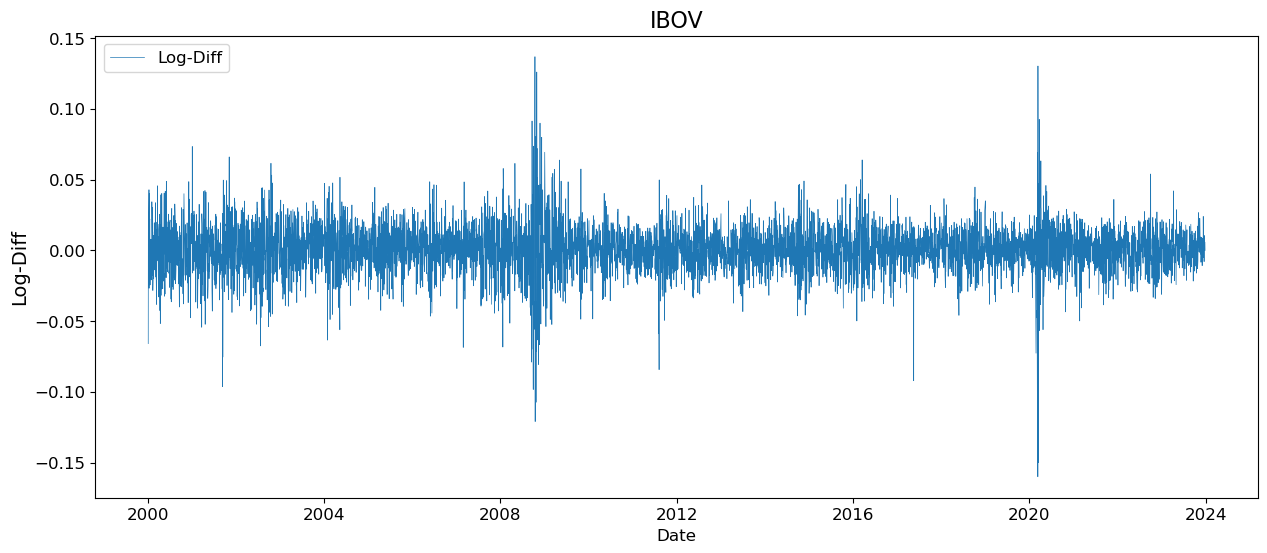

In [116]:
#===============================================================================================================================
# LOG-DIFF - DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(data.index, data['Close'], label = "Log-Diff", linewidth=0.5)
plt.title(seriesId, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log-Diff', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc=2, prop={'size': 12}, bbox_to_anchor=(0,1))
plt.show()

In [117]:
ADF_Close = adfuller(data['Close'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')


ADF Statistic: -16.89
ADF p-value  : 0.0


In [118]:
#===============================================================================================================================
# LOG-DIFF - TRANSF: ESTIMATES d
#===============================================================================================================================
out = d_estimates_db(data,0,1)
out


d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.993
d_estimates_db: d = 0.2   correlation = 0.976
d_estimates_db: d = 0.3   correlation = 0.952
d_estimates_db: d = 0.4   correlation = 0.924
d_estimates_db: d = 0.5   correlation = 0.892
d_estimates_db: d = 0.6   correlation = 0.858
d_estimates_db: d = 0.7   correlation = 0.824
d_estimates_db: d = 0.8   correlation = 0.788
d_estimates_db: d = 0.9   correlation = 0.752
d_estimates_db: d = 1.0   correlation = 0.717


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-16.889955,1.046976e-29,17.0,5924.0,-2.862028,1.000000
0.1,-34.926241,0.000000e+00,5.0,5434.0,-2.862072,0.993314
0.2,-19.437301,0.000000e+00,18.0,5427.0,-2.862073,0.976386
0.3,-18.374329,2.215230e-30,24.0,5530.0,-2.862063,0.952271
0.4,-19.545537,0.000000e+00,25.0,5635.0,-2.862053,0.923726
0.5,-20.694084,0.000000e+00,25.0,5717.0,-2.862046,0.891807
0.6,-21.891064,0.000000e+00,25.0,5777.0,-2.862040,0.858066
0.7,-20.768953,0.000000e+00,30.0,5815.0,-2.862037,0.823515
0.8,-21.700619,0.000000e+00,30.0,5848.0,-2.862034,0.787705
0.9,-21.668648,0.000000e+00,32.0,5872.0,-2.862032,0.752208


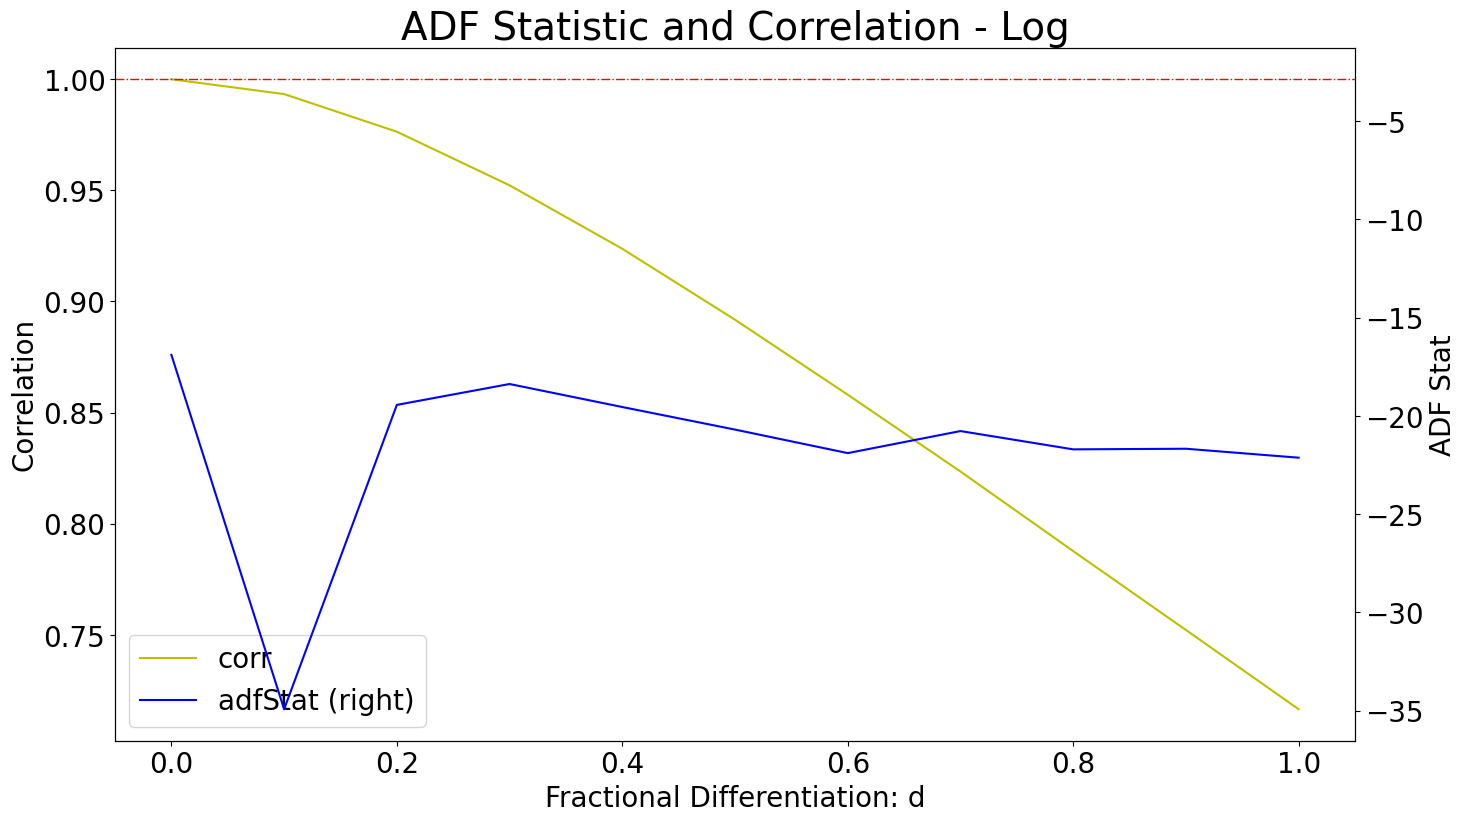

In [119]:
#===============================================================================================================================
# LOG-DIFF - TRANSF: - ADF Stat, CORR vs d
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# Plot: out For d = 0.3 , p-value = 0.048, correlation = 0.85 > 0.8 (critical point).
#-------------------------------------------------------------------------------------------------------------------------------
ax1 = out['corr'].plot(figsize=(16, 9), color='y')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='b', ax=ax1)
ax1.set_title('ADF Statistic and Correlation - Log', fontsize=28)
ax1.set_xlabel('Fractional Differentiation: d', fontsize=20)
ax1.set_ylabel('Correlation', fontsize=20)
ax2.set_ylabel('ADF Stat', fontsize=20)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)
plt.axhline(out['95% conf'].mean(),linewidth=1, color='r',linestyle='-.');
# Tip!
# To get 2 legends aligned without overlapping:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)

In [120]:
#===============================================================================================================================
# LOG-DIFF - TRANSF: OPTIMAL d
#===============================================================================================================================
d = optimal_d(data, 0.035, 0, 1)
d
#-------------------------------------------------------------------------------------------------------------------------------
# d = 0.
#-------------------------------------------------------------------------------------------------------------------------------

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.993
d_estimates_db: d = 0.2   correlation = 0.976
d_estimates_db: d = 0.3   correlation = 0.952
d_estimates_db: d = 0.4   correlation = 0.924
d_estimates_db: d = 0.5   correlation = 0.892
d_estimates_db: d = 0.6   correlation = 0.858
d_estimates_db: d = 0.7   correlation = 0.824
d_estimates_db: d = 0.8   correlation = 0.788
d_estimates_db: d = 0.9   correlation = 0.752
d_estimates_db: d = 1.0   correlation = 0.717


0.0

In [121]:
#===============================================================================================================================
# LOG-DIFF - TRANSF: RESIDUALS
#===============================================================================================================================
fracdiff_residuals = fracDiff_FFD(data['Close'],d)

fracdiff_residuals

,Close
2000-01-04,-0.065879
2000-01-05,0.024561
2000-01-06,-0.008547
2000-01-07,0.012479
2000-01-10,0.042788
...,...
2023-12-21,0.010479
2023-12-22,0.004310
2023-12-26,0.005858
2023-12-27,0.004936


In [122]:
#===============================================================================================================================
# LOG-DIFF - STATIONARITY: ADF Test
#===============================================================================================================================
df2=adfuller(fracdiff_residuals, regression='c', autolag='AIC')
ADF_statistics = df2[0]
p_value = df2[1]
print('ADF statistics =', round(ADF_statistics,2),chr(9), 'p_value =', round(p_value,3))

#-------------------------------------------------------------------------------------------------------------------------------
# ADF statistics = -16.89 	 p_value = 0.0 < 0.05
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF statistics = -16.89 	 p_value = 0.0


In [123]:
#===============================================================================================================================
# LOG-DIFF - CORRELATION
#===============================================================================================================================
fracdiff_residuals.rename(columns={'Close':'Residuals'}, inplace=True)
new_df = pd.concat([data['Close'], fracdiff_residuals], axis=1).dropna()
print('Correlation = ', round(new_df.corr().loc['Close','Residuals'],4))

#-------------------------------------------------------------------------------------------------------------------------------
# Correlation =  0.9547
#-------------------------------------------------------------------------------------------------------------------------------

Correlation =  1.0
